## Project: Build a Traffic Sign Recognition Classifier

The present work designs and develops a deep convolutional neural network architecture to classify german traffic signs

---
## Step 1: Load the data and summarize

In [1]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf


# Fill this in based on where you saved the training and testing data
training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

### Dataset summary

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_test)+list(y_train)+list(y_valid)))

class_labels = []
with open('signnames.txt','r') as f:
    s = f.read() 
    class_labels = s.split('\n')
    class_labels.pop()

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

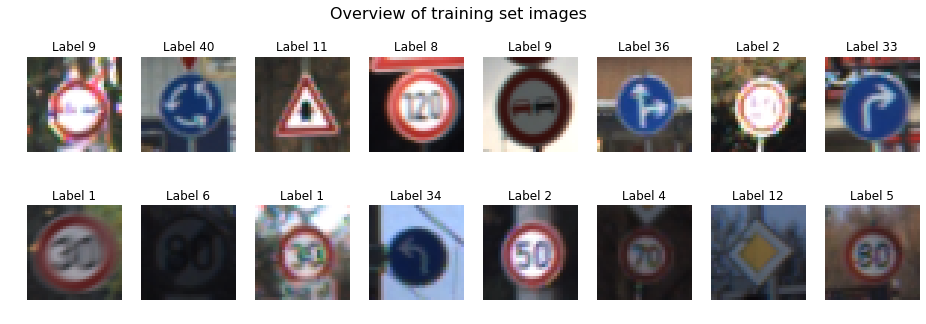

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def random_index(i):
    return np.random.randint(0, i)

rows = 2
cols = 8
fig, ax = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(16,5))

for i in range(rows):
    for j in range(cols):
        rand_indx = random_index(n_train-1)
        ax[i,j].imshow(X_train[rand_indx])
        ax[i,j].set_title('Label {}'.format(y_train[rand_indx]))
        ax[i,j].axis('off')  # clear x- and y-axes
fig.suptitle('Overview of training set images', fontsize=16)
plt.show()

## Histogram of class image distribution in training set

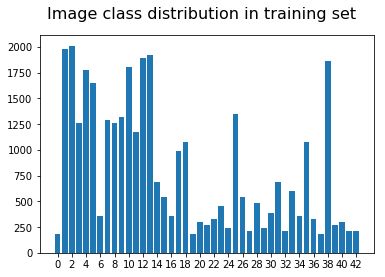

In [4]:
# Draw a histogram of how many features we have per label
# Store the number of images present in the training set for a given label
bincounts = []
# Store the indexes of all the images in the training set for a given label
classes_indexes = []
# Image label vector
x = np.arange(n_classes)

for i in range(n_classes):
    classes_indexes.append(np.where(y_train==i)[0])
    bincounts.append(len(classes_indexes[-1]))
fig, ax = plt.subplots()
fig.suptitle('Image class distribution in training set', fontsize=16)
ax.bar(x, bincounts)
plt.xticks(x[0::2])
plt.show()

#This array stores those classes with a number of samples > 1250
bigc = np.argwhere((np.array(bincounts)>1250)==True)


## Representation of images per class label

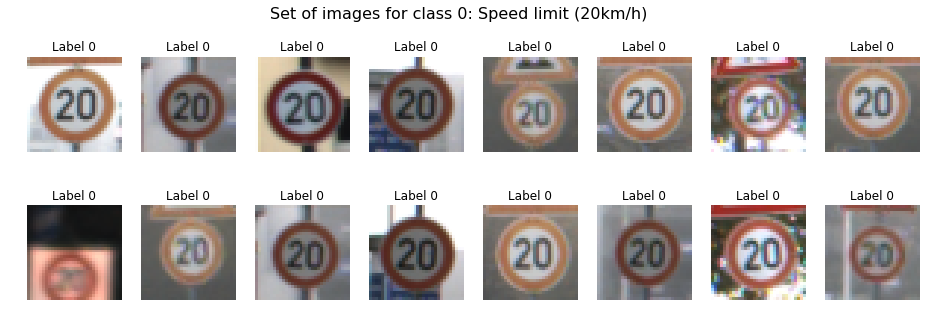

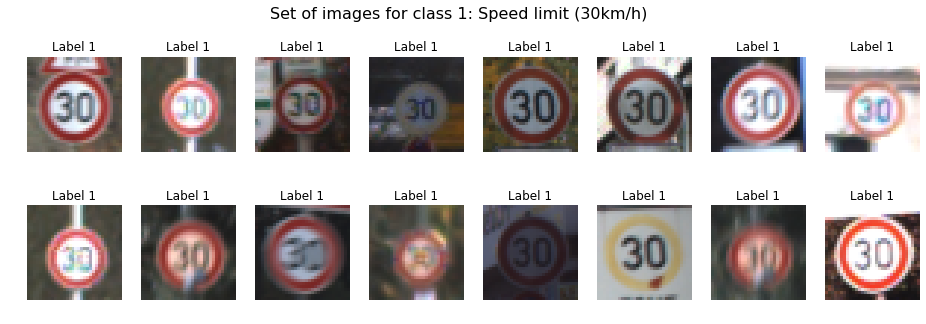

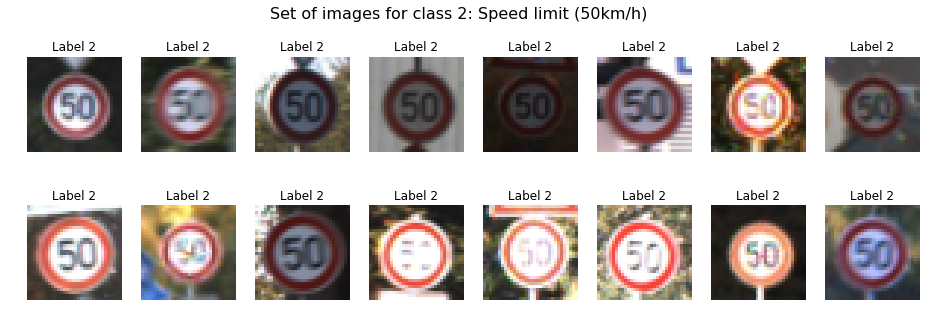

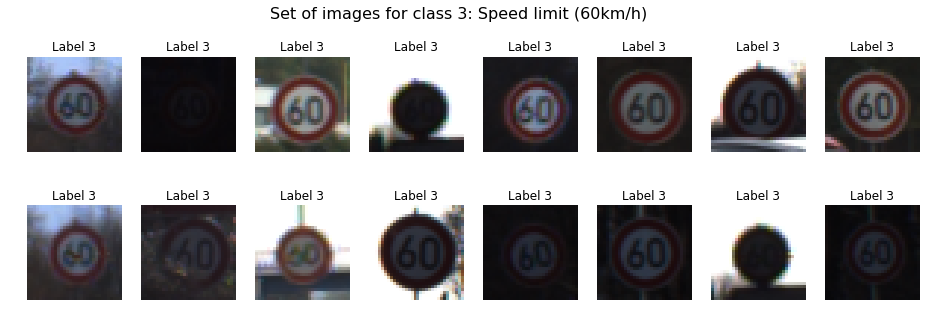

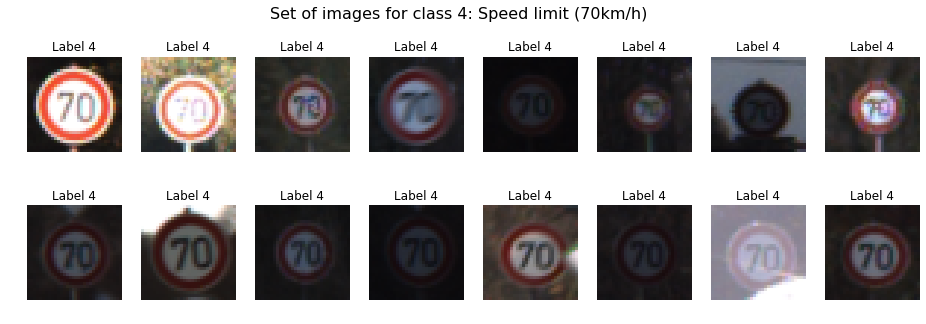

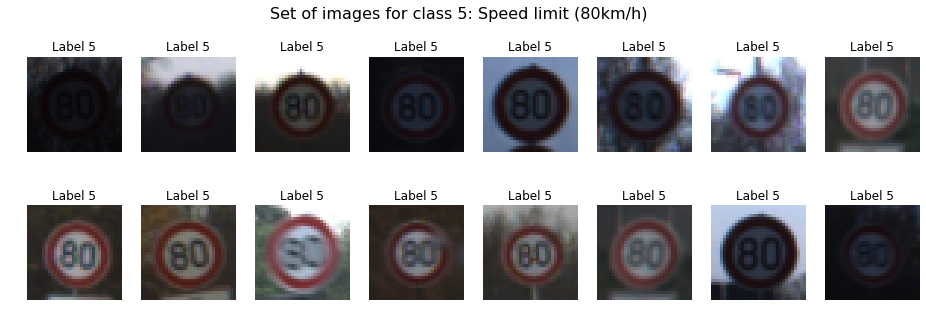

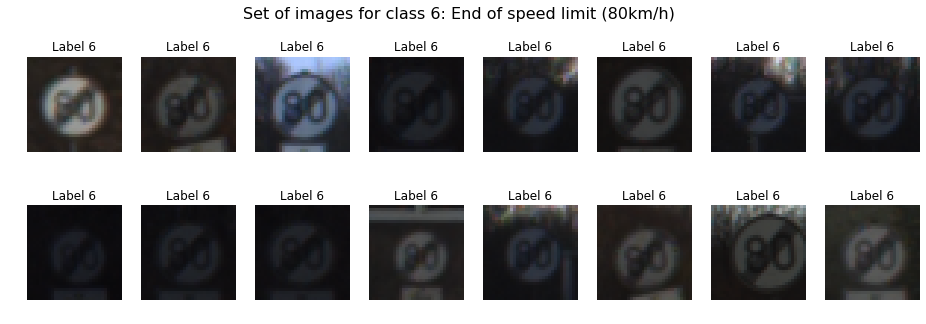

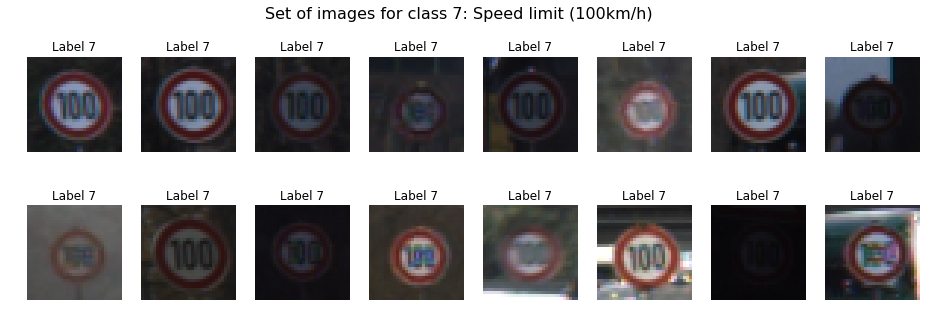

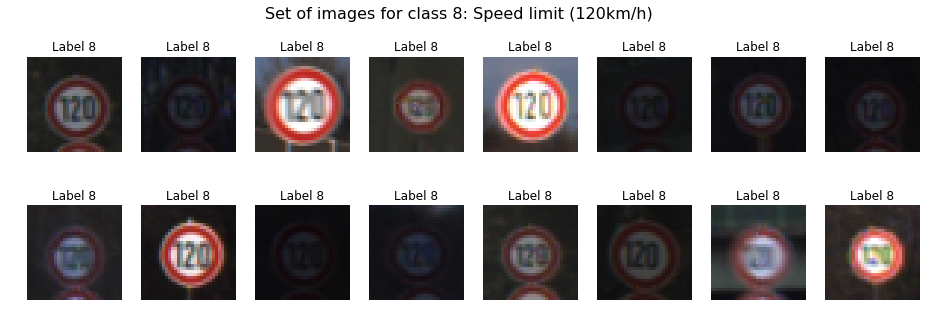

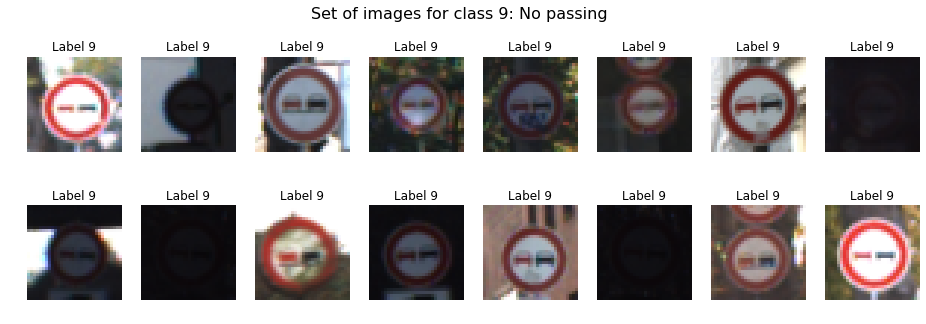

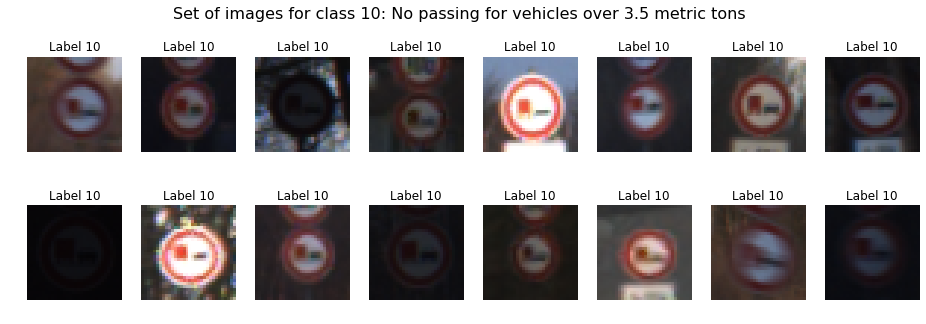

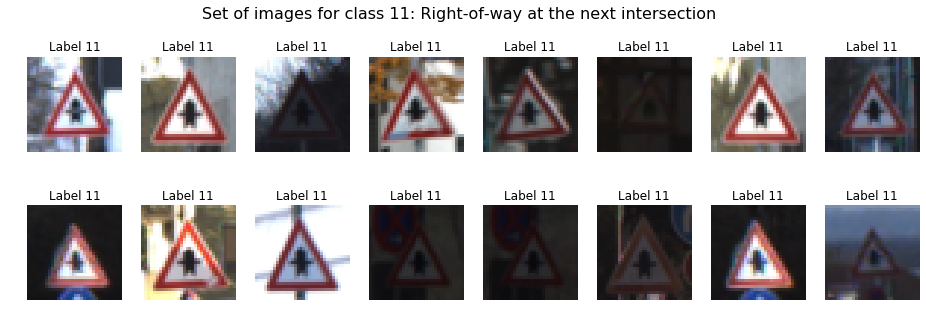

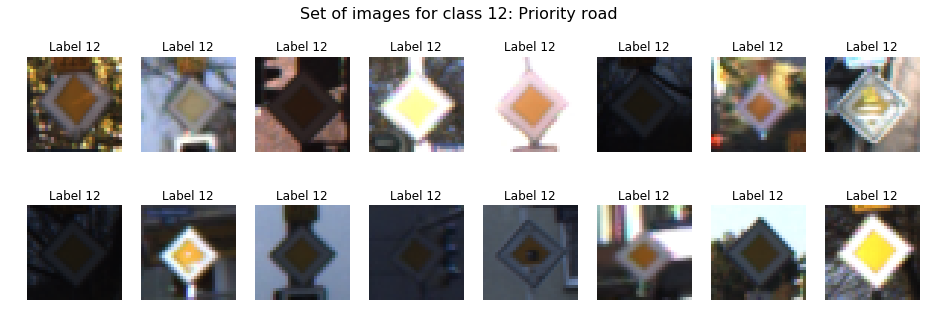

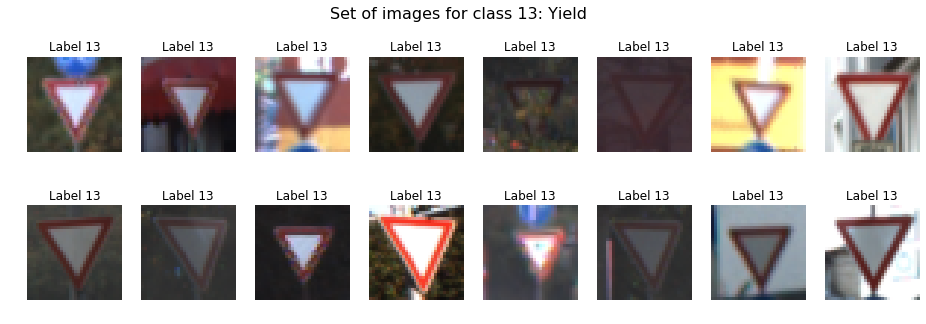

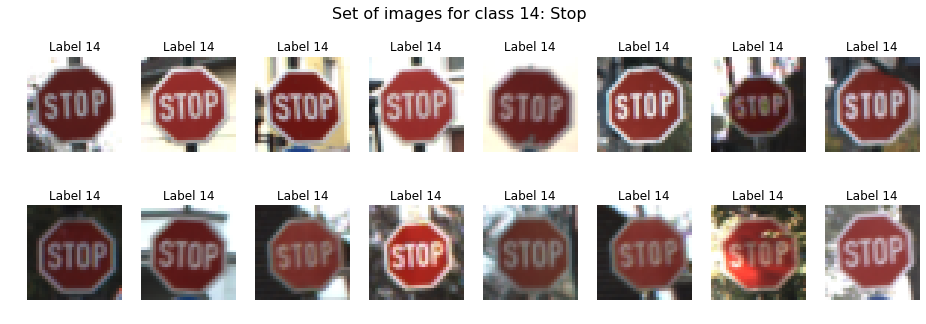

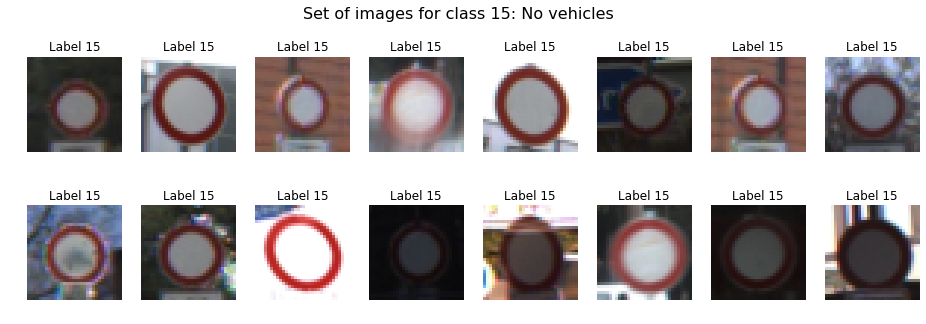

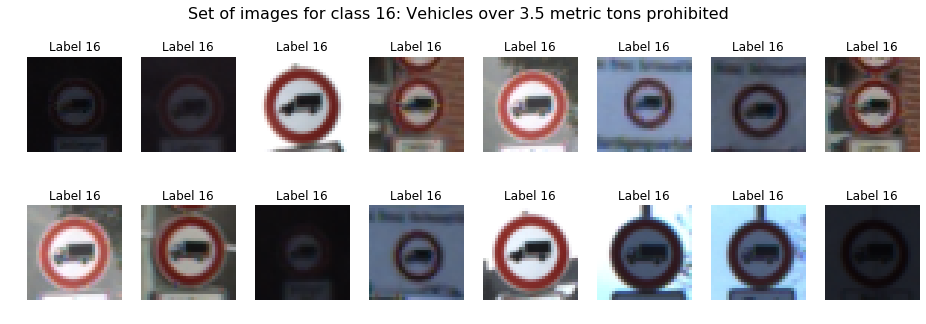

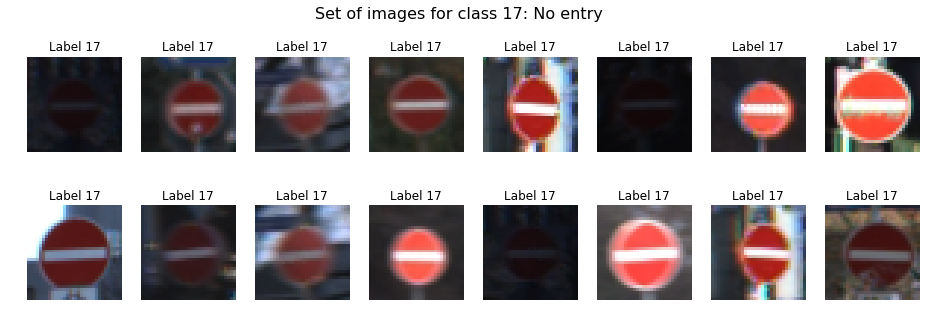

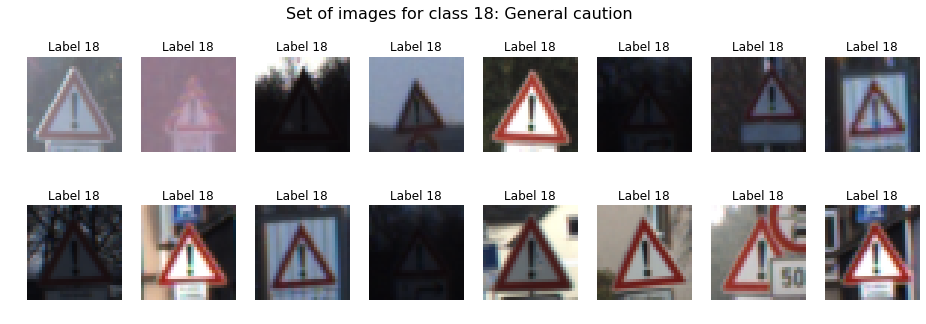

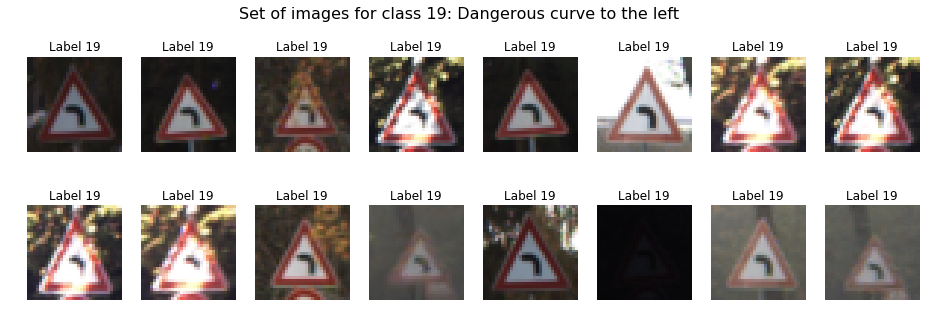

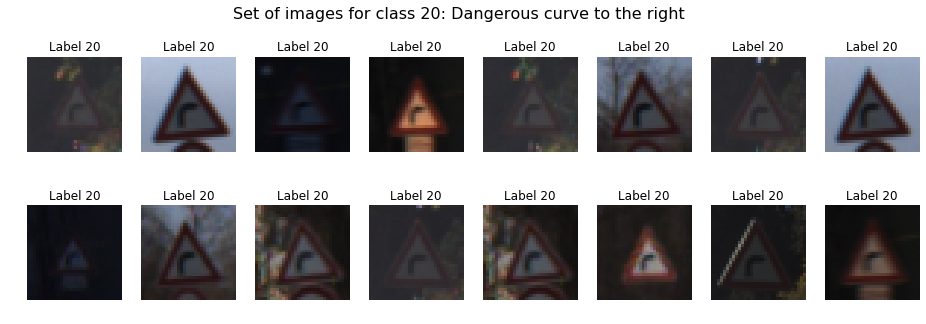

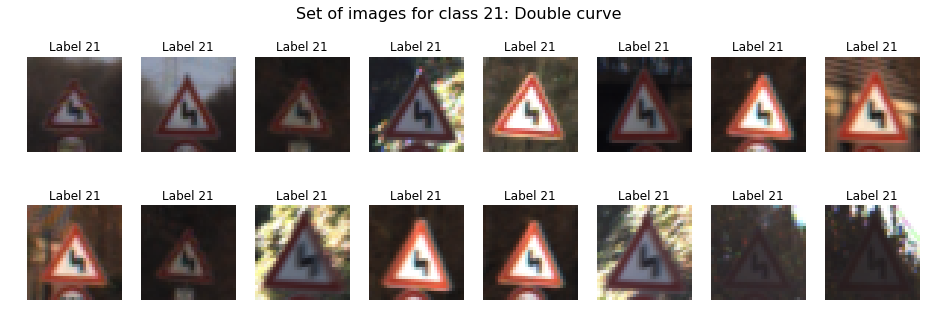

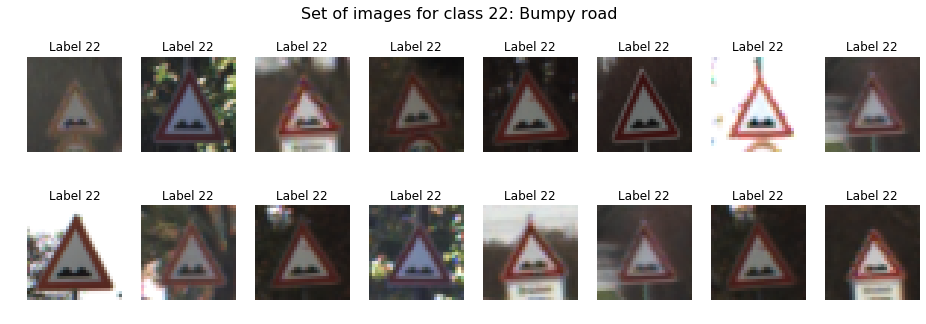

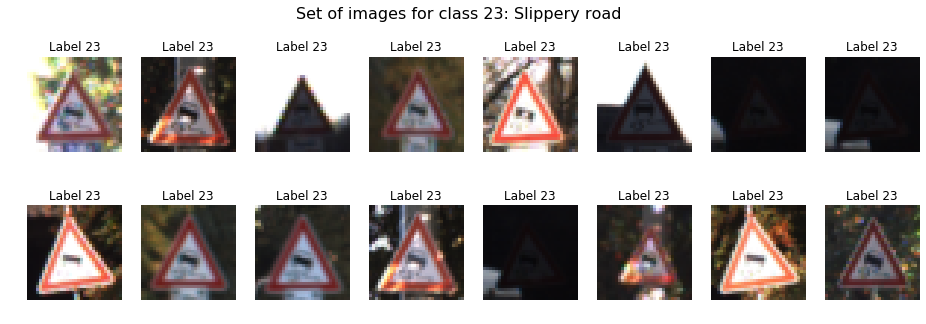

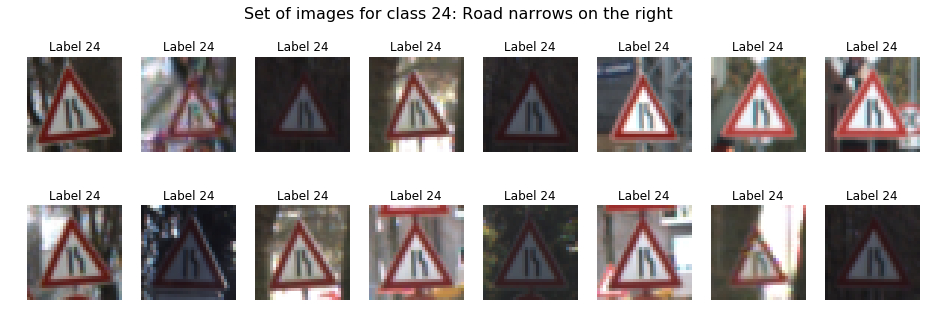

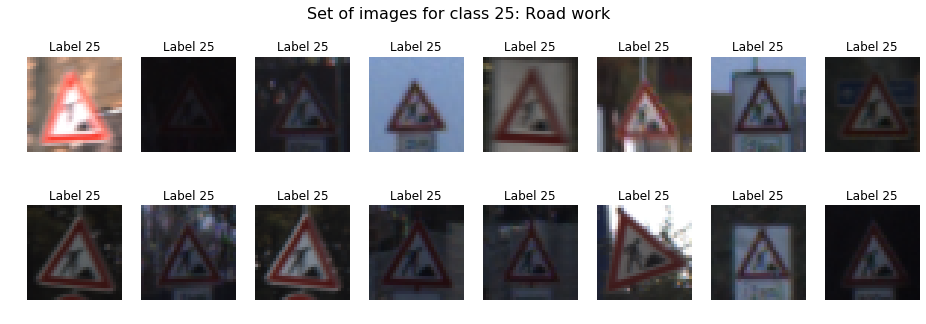

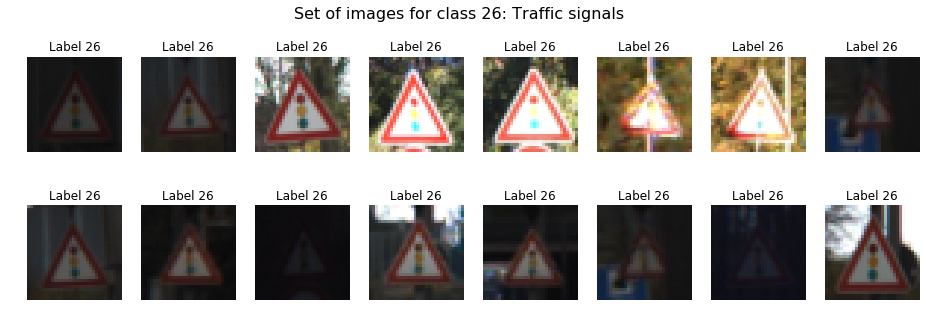

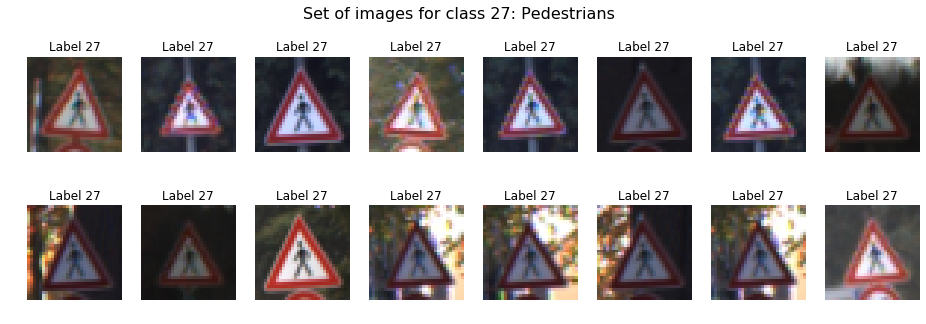

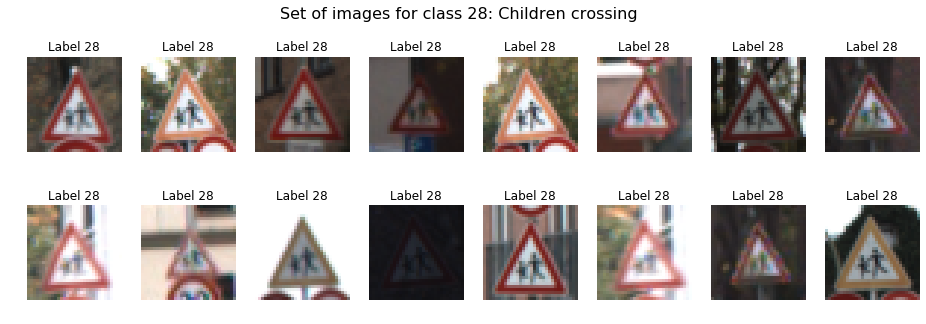

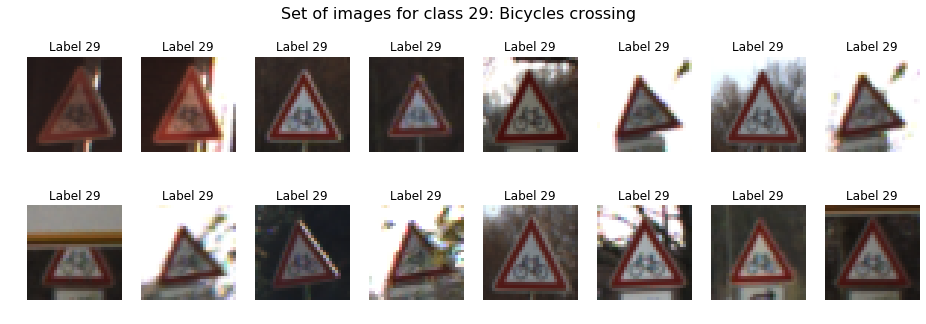

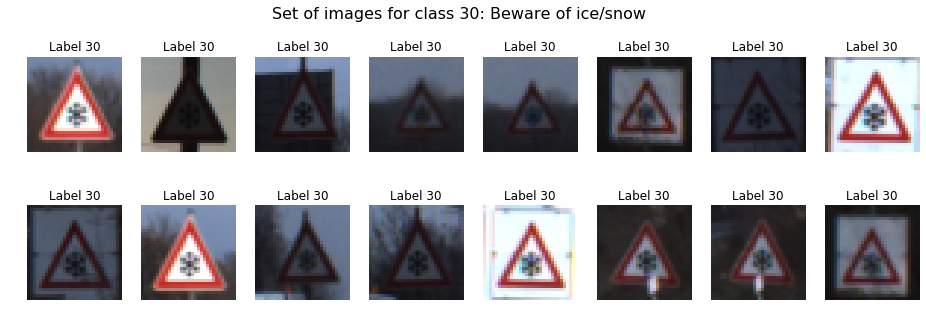

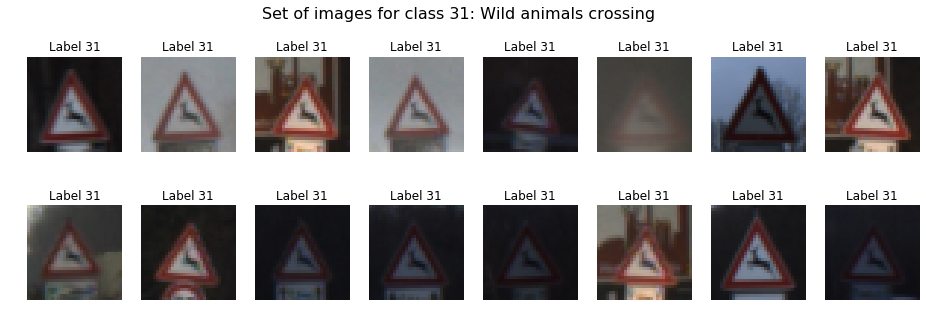

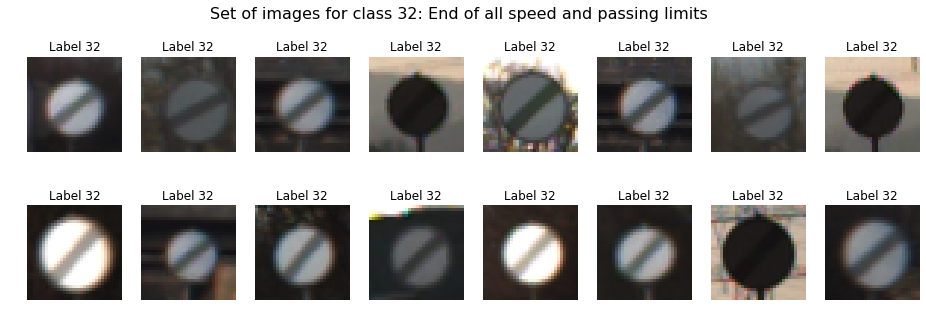

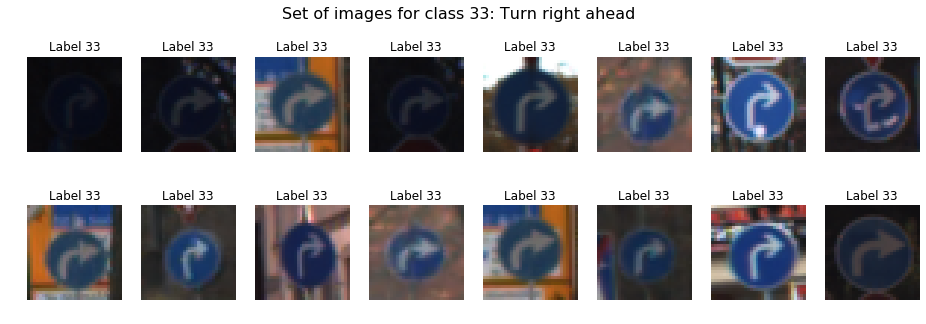

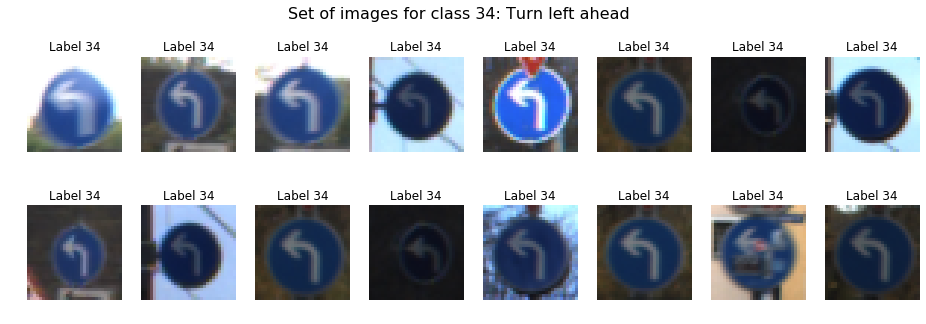

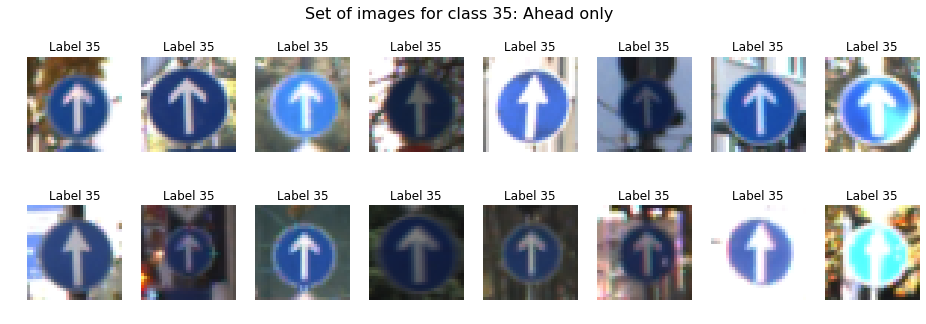

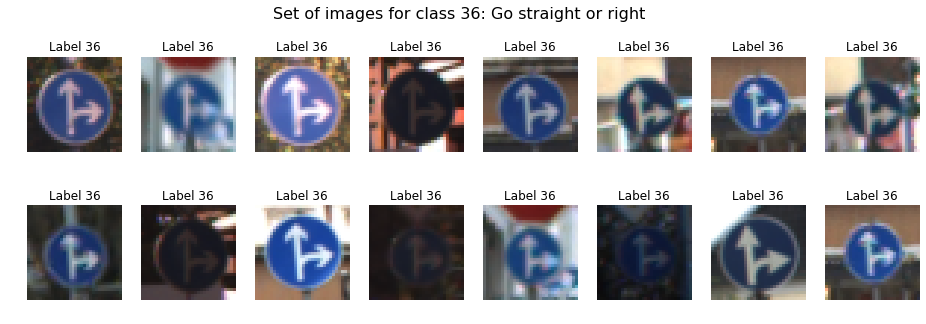

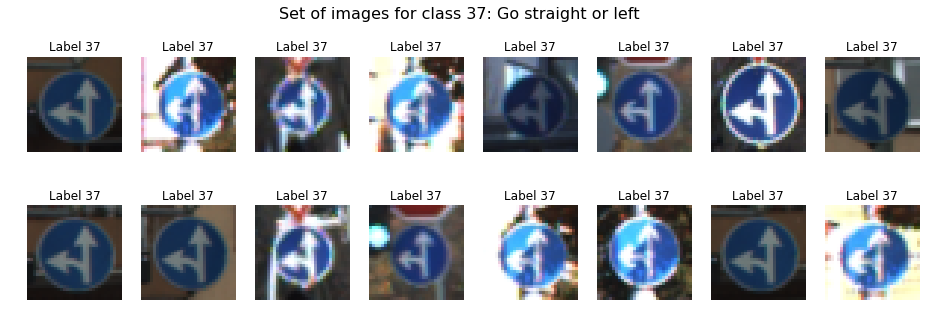

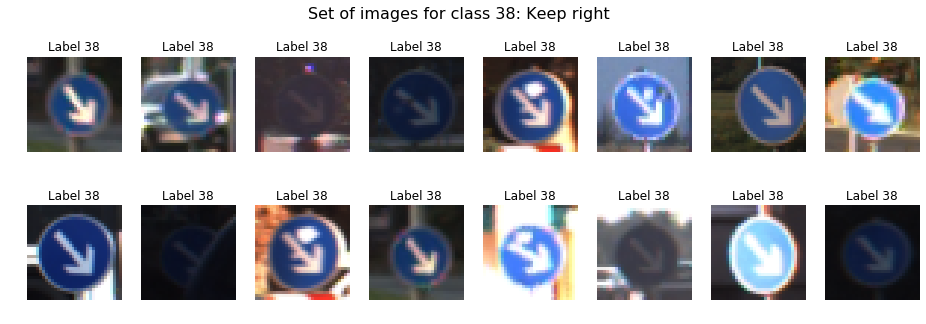

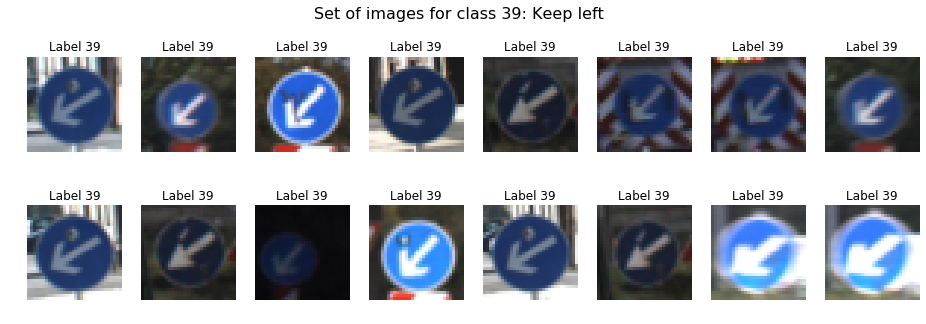

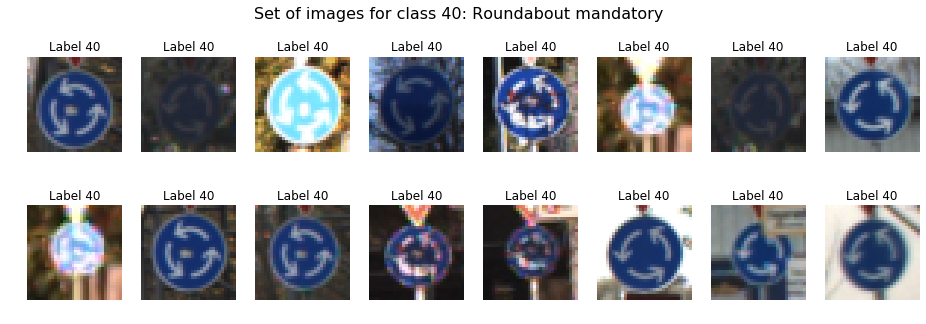

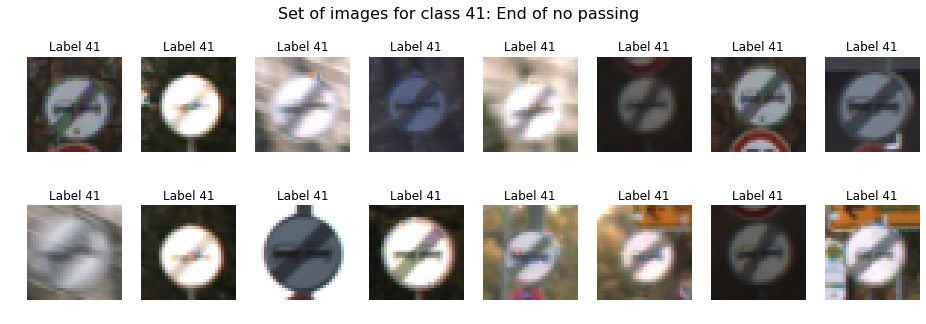

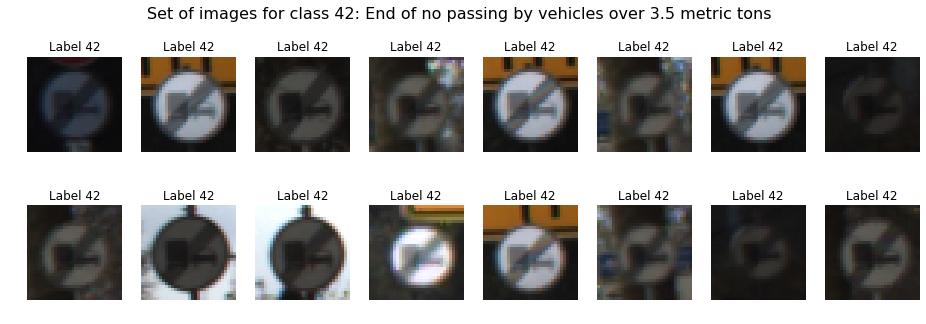

In [5]:
rows = 2
cols = 8

for c in range(len(classes_indexes)):
    fig, ax = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(16,5))
    for i in range(rows):
        for j in range(cols):
            rand_indx = np.random.randint(0, len(classes_indexes[c])-1)
            ax[i,j].imshow(X_train[classes_indexes[c][rand_indx]])
            ax[i,j].set_title('Label {}'.format(y_train[classes_indexes[c][rand_indx]]))
            ax[i,j].axis('off')  # clear x- and y-axes
    fig.suptitle('Set of images for class {}: {}'.format(c, class_labels[c]), fontsize=16)
    #plt.savefig('class_{}.png'.format(c))
    plt.show()

## Data augmentation

The following data augmentation techniques are used in the process:

* Cropping
* Rotation
* Scaling
* Translation
* ~~Gaussian blur~~
* ~~Contrast normalization~~
* ~~Additive Gaussian Noise~~


In [6]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(1)

# Example batch of images.
# The array has shape (?, 32, 32, 3) and dtype uint8.

seq = iaa.Sequential([
    #iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    #iaa.Sometimes(0.5,
    #    iaa.GaussianBlur(sigma=(0, 0.5))
    #),
    # Strengthen or weaken the contrast in each image.
    #iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        #shear=(-8, 8),
        rotate=(-15, 15)
    )
], random_order=True) # apply augmenters in random order


In [7]:
print('Image and label set shapes before data set augmentation: {} , {}'.format(X_train.shape, y_train.shape))

Image and label set shapes before data set augmentation: (34799, 32, 32, 3) , (34799,)


In [8]:
from IPython.display import clear_output, display
print('Starting image augumentation...\n')
for i in range(n_classes):
    if bincounts[i] < 1250:
        cycles = 2000//bincounts[i]
        for counter in range(cycles):
            class_img = X_train[classes_indexes[i]]
            y_img = y_train[classes_indexes[i]]
            augmented_images = seq.augment_images(class_img)
            X_train = np.concatenate((X_train, augmented_images))
            y_train = np.concatenate((y_train, y_img))
    else:
        class_img = X_train[classes_indexes[i]][0:1000]
        y_img = y_train[classes_indexes[i]][0:1000]
        augmented_images = seq.augment_images(class_img)
        X_train = np.concatenate((X_train, augmented_images))
        y_train = np.concatenate((y_train, y_img))
    clear_output(wait=True)
    print('Augmentation of class {} completed \n'.format(i))

print('Image and label set shapes after data set augmentation: {} , {}'.format(X_train.shape, y_train.shape))

Augmentation of class 42 completed 

Image and label set shapes after data set augmentation: (100656, 32, 32, 3) , (100656,)


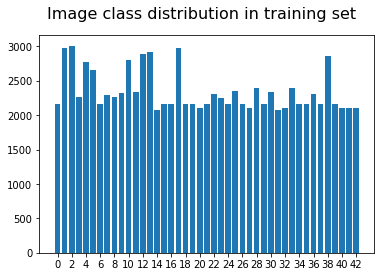

In [9]:
# Draw a histogram of how many features we have per label
# Store the number of images present in the training set for a given label
bincounts = []
# Store the indexes of all the images in the training set for a given label
classes_indexes = []
# Image label vector|
x = np.arange(n_classes)

for i in range(n_classes):
    classes_indexes.append(np.where(y_train==i)[0])
    bincounts.append(len(classes_indexes[-1]))
fig, ax = plt.subplots()
fig.suptitle('Image class distribution in training set', fontsize=16)
ax.bar(x, bincounts)
plt.xticks(x[0::2])
plt.show()

## Representation of images per class label after augmentation

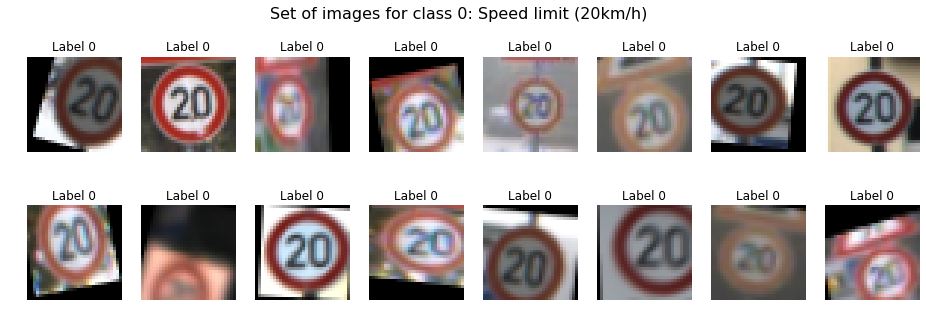

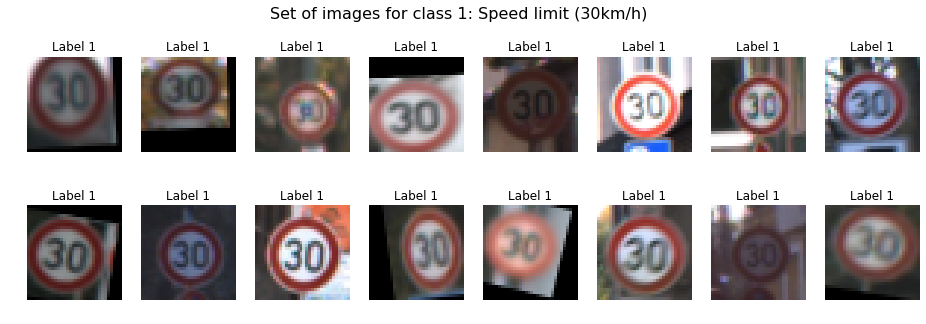

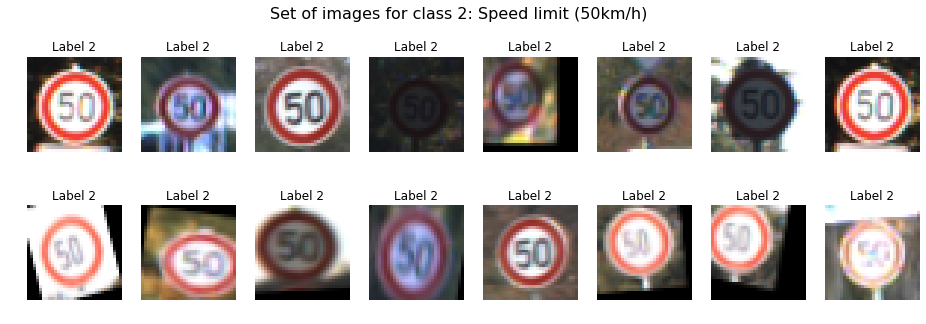

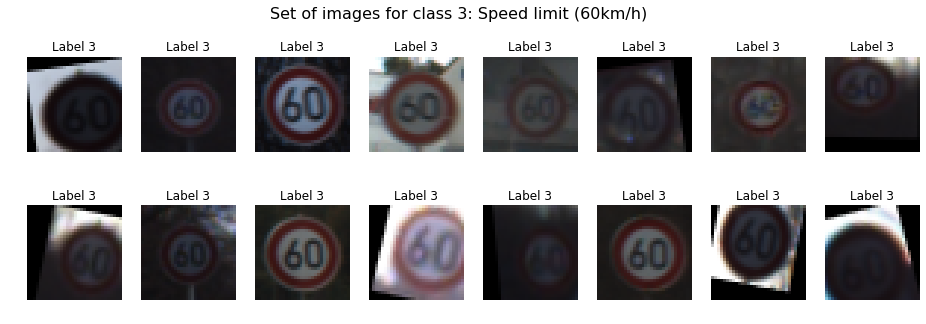

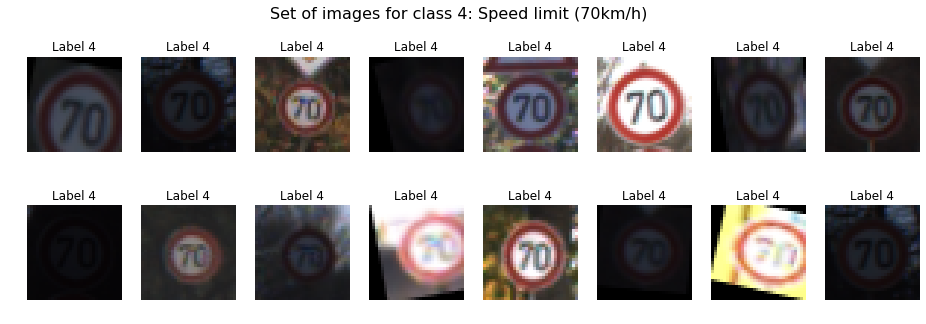

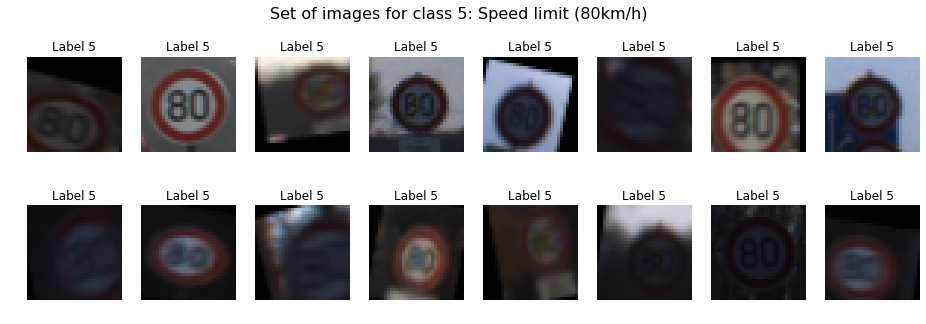

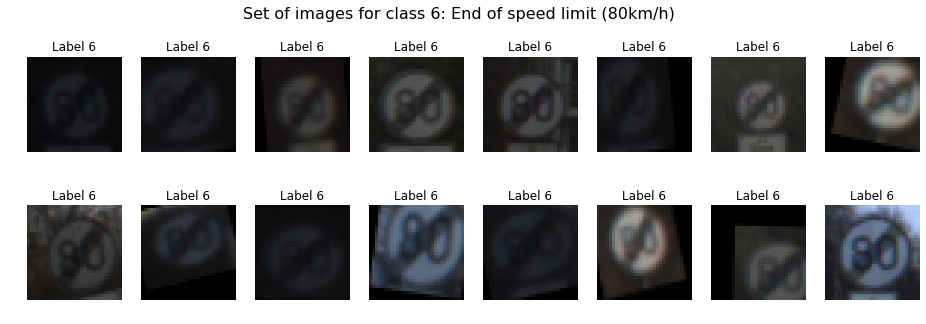

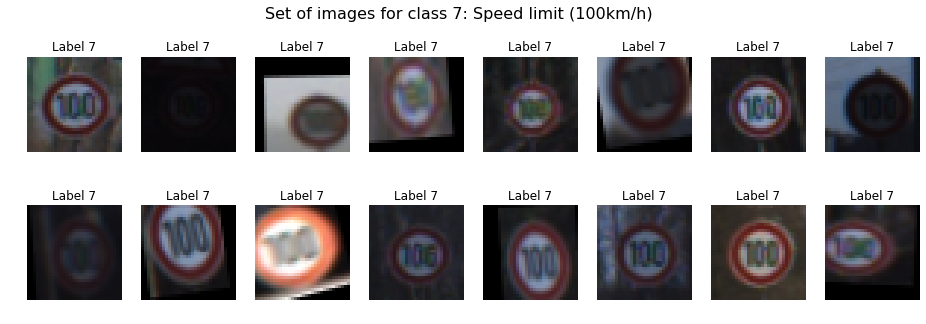

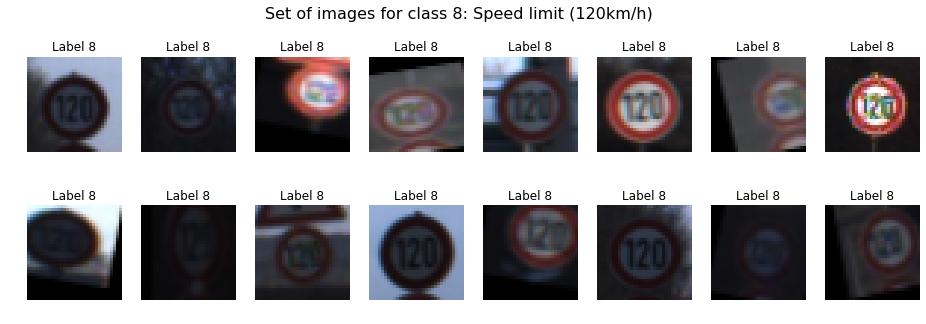

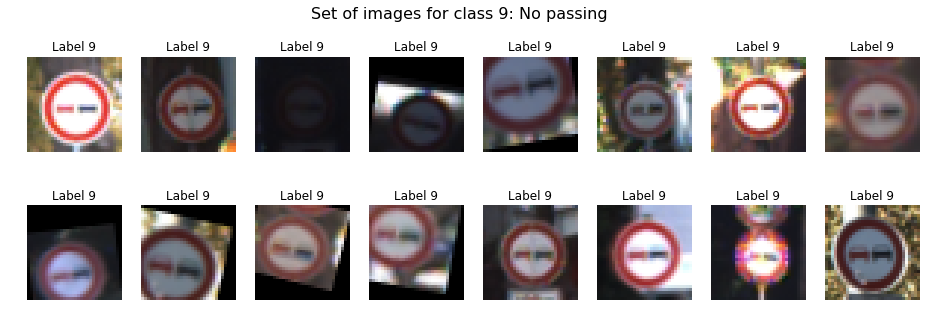

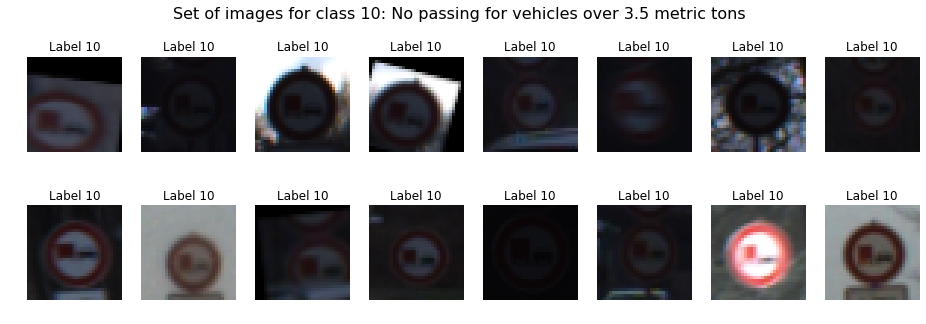

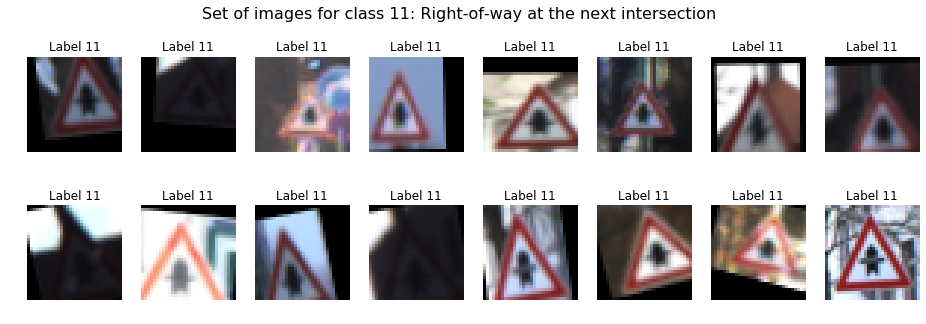

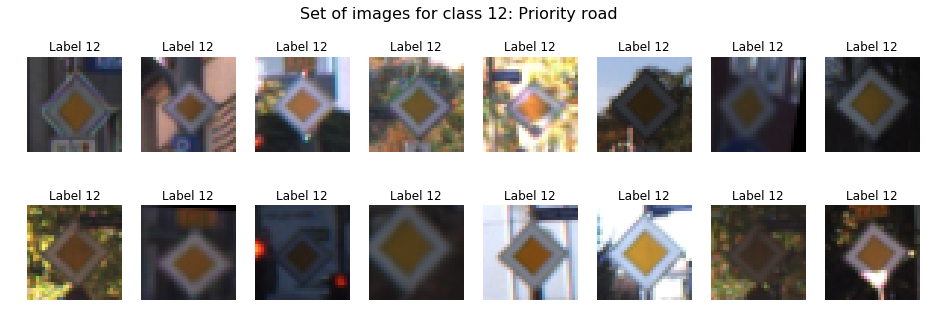

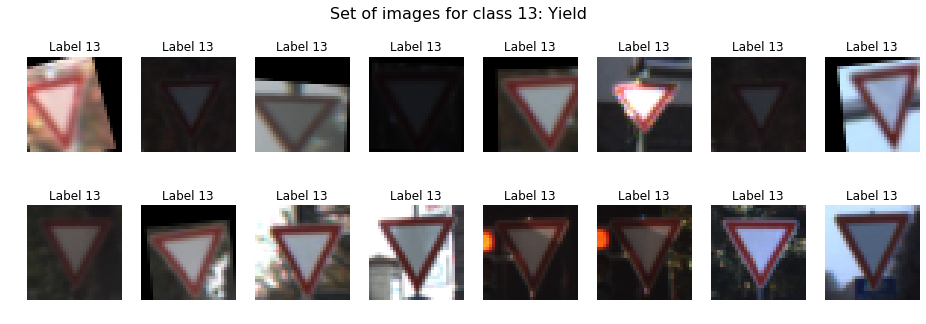

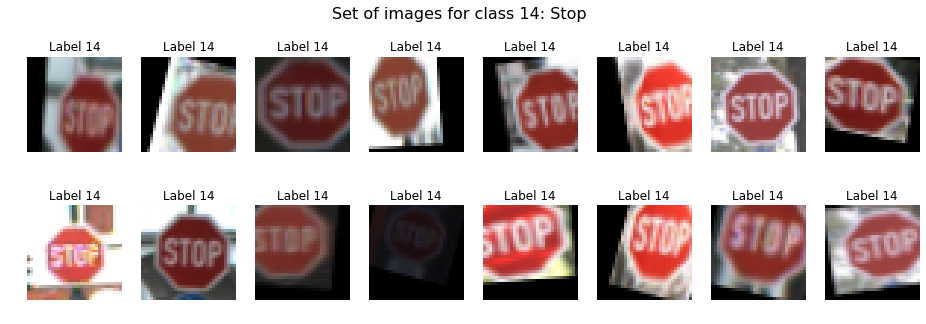

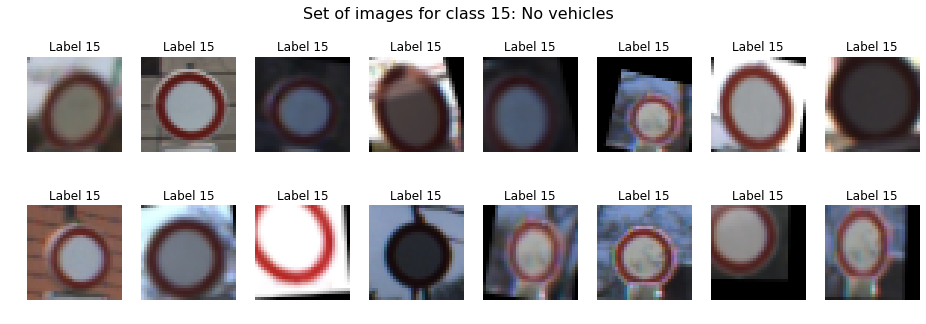

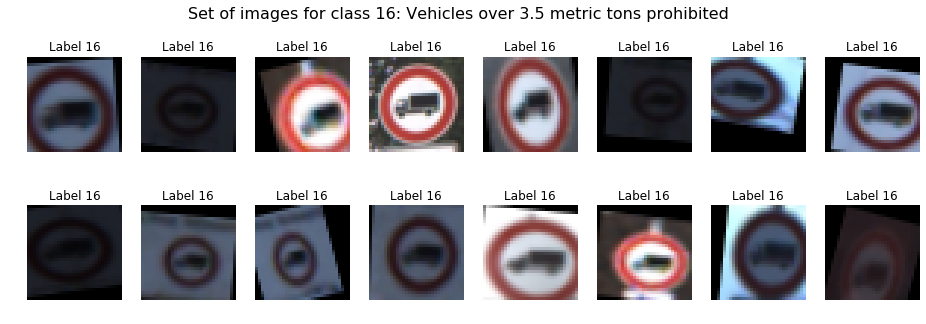

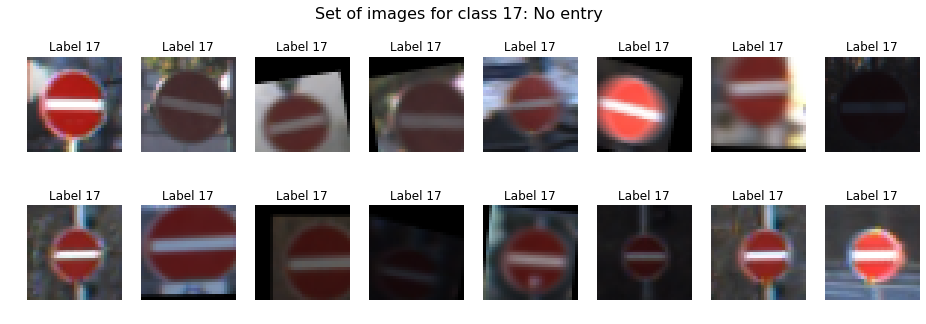

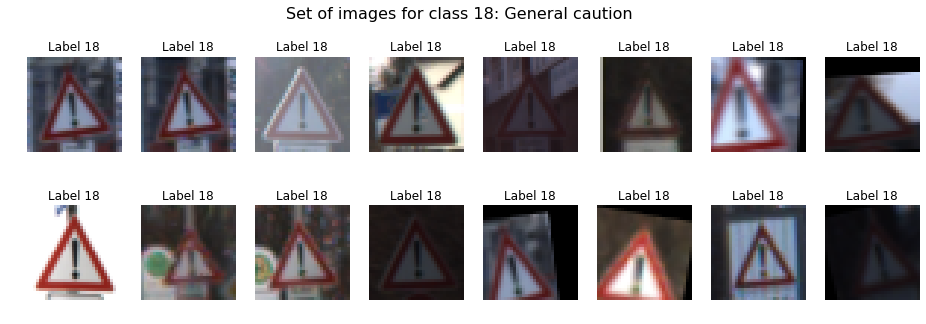

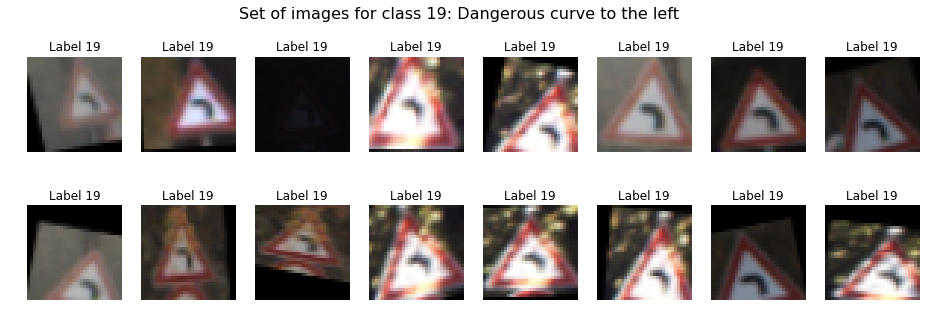

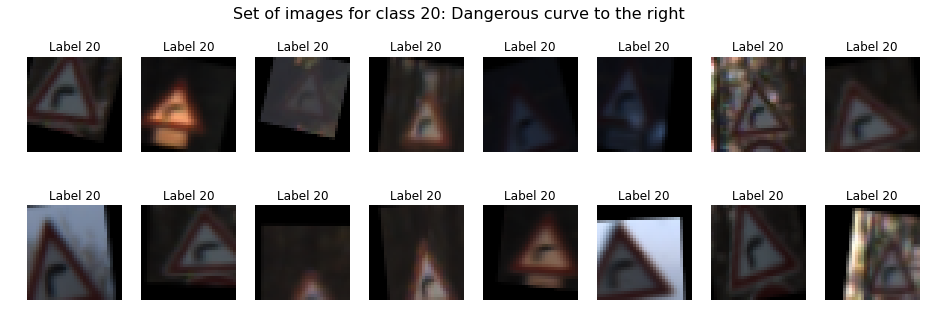

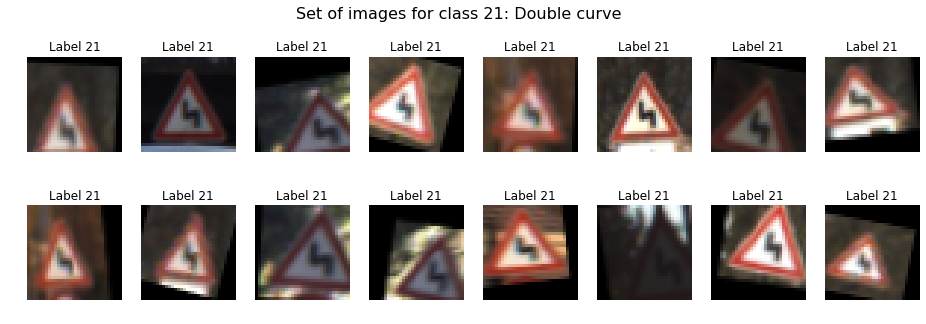

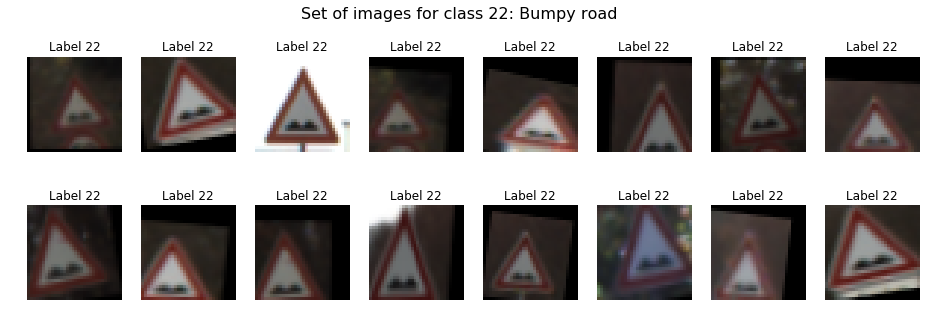

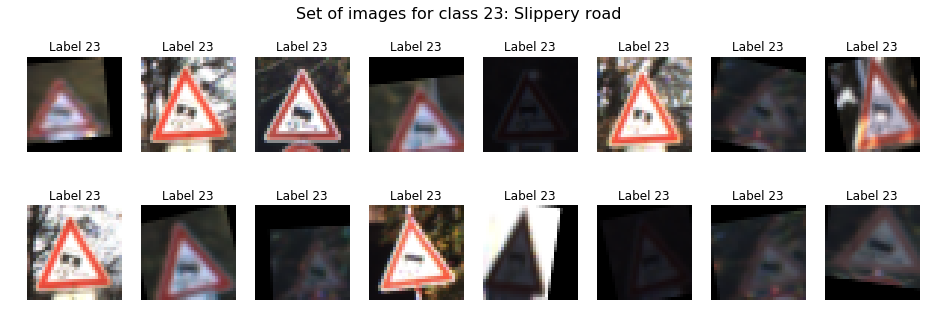

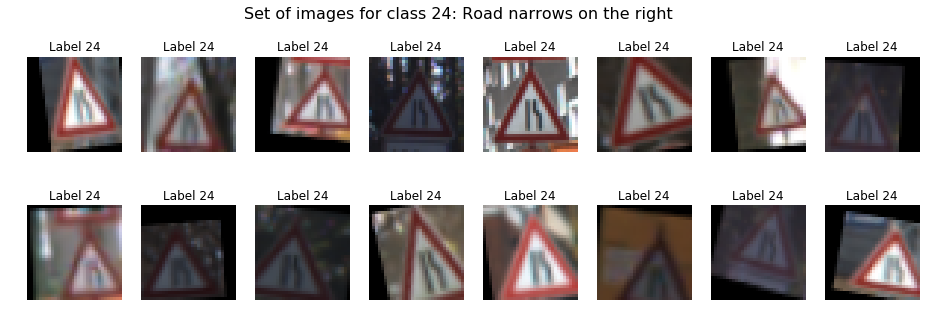

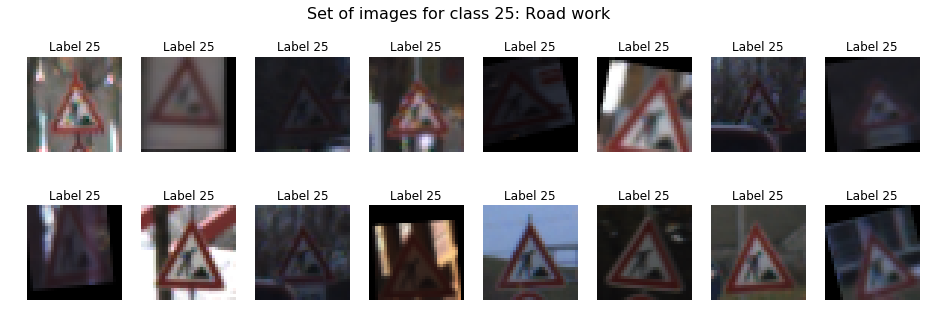

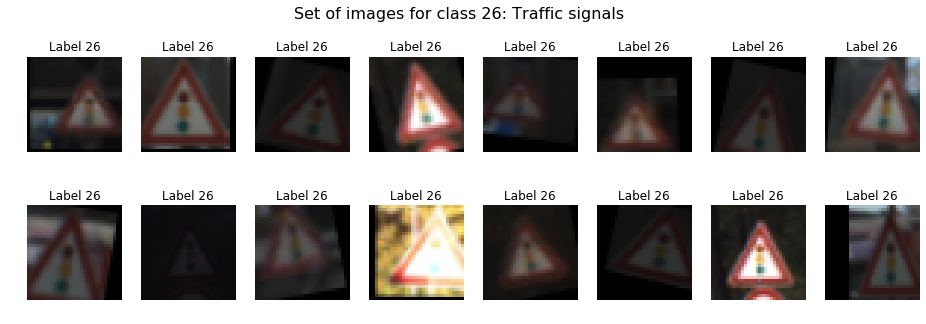

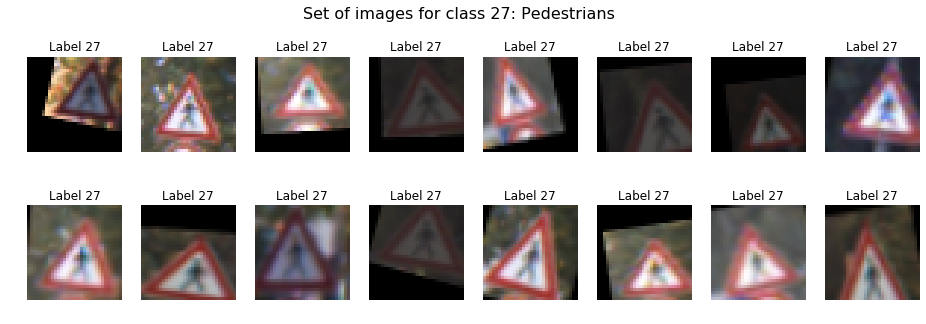

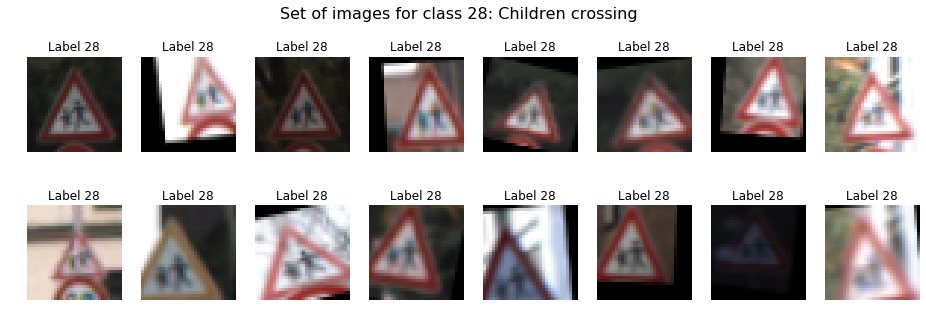

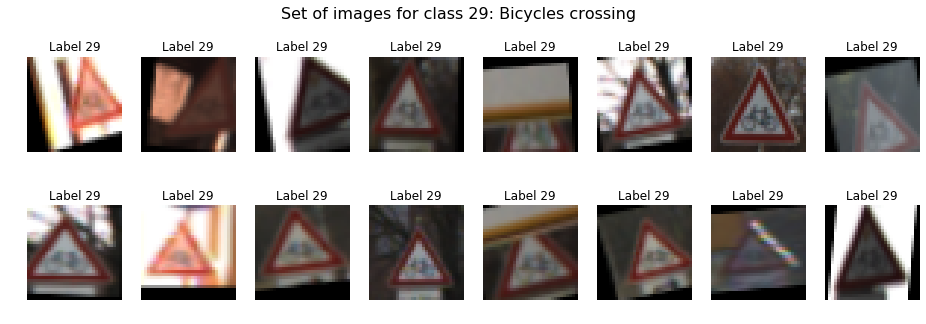

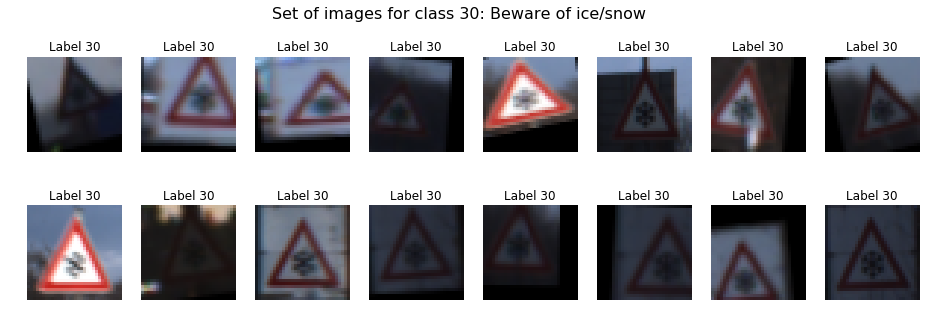

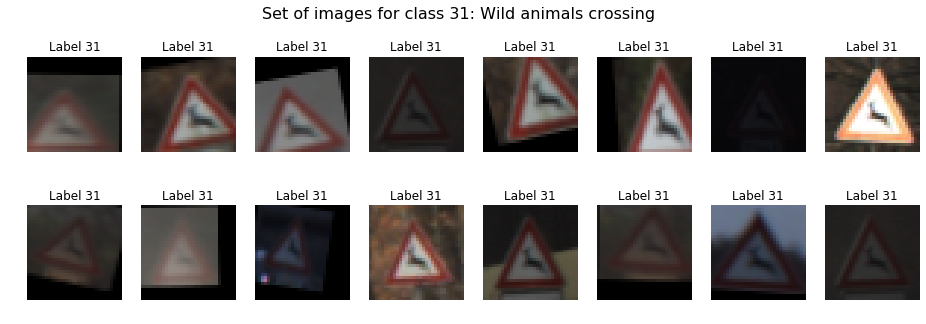

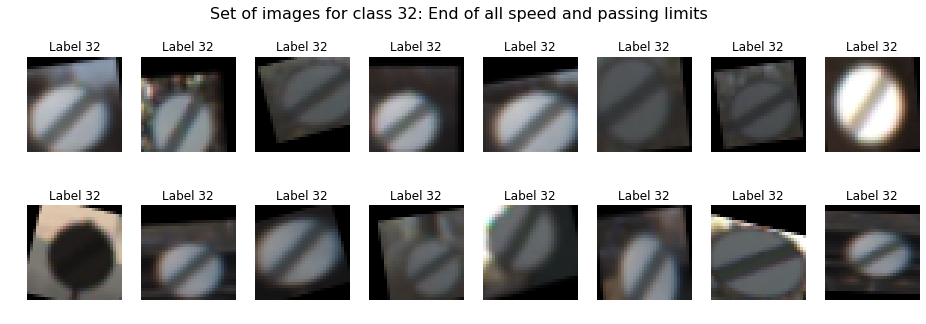

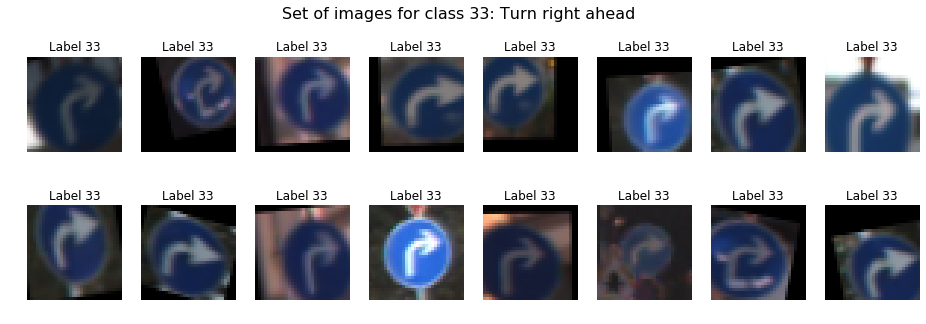

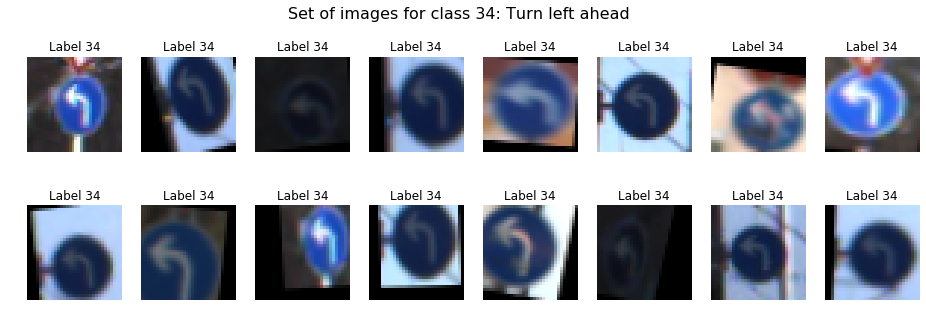

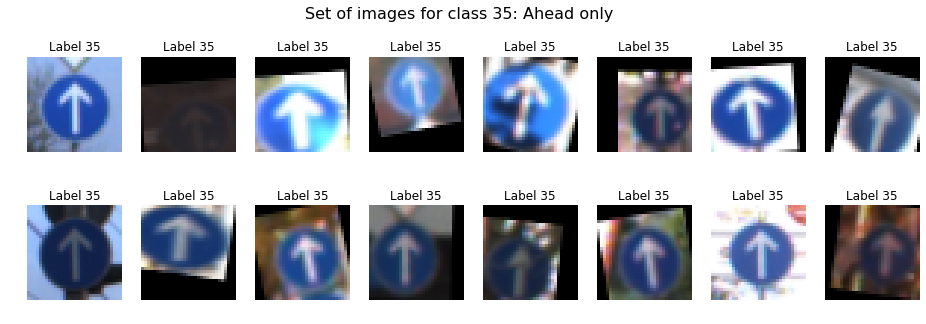

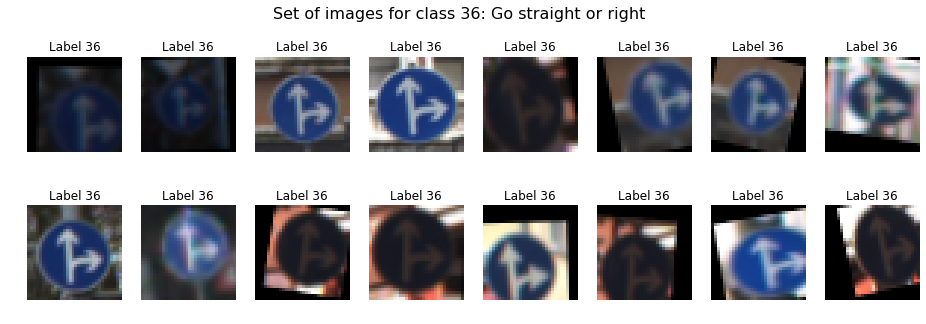

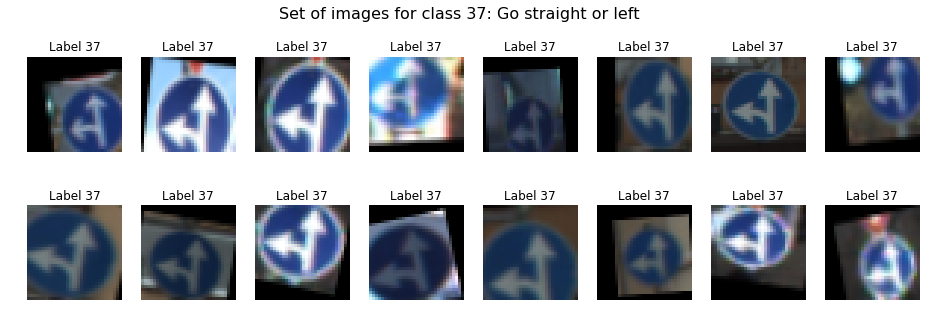

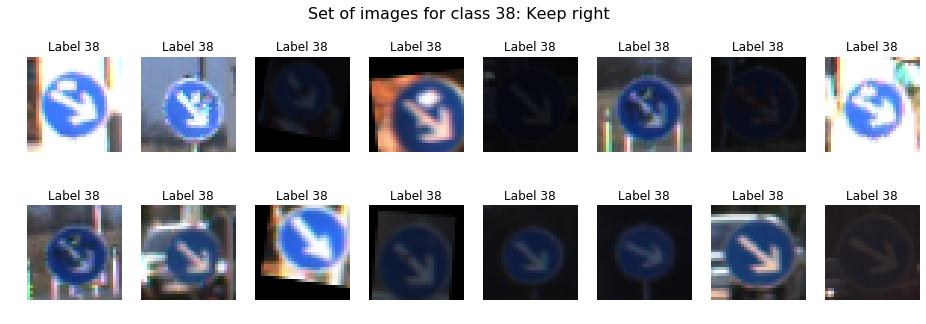

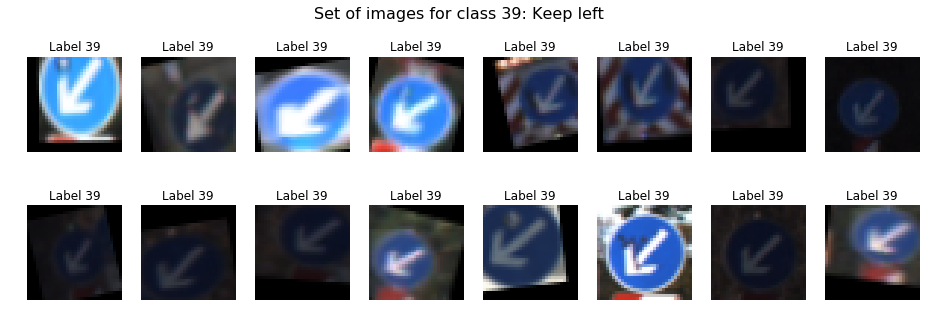

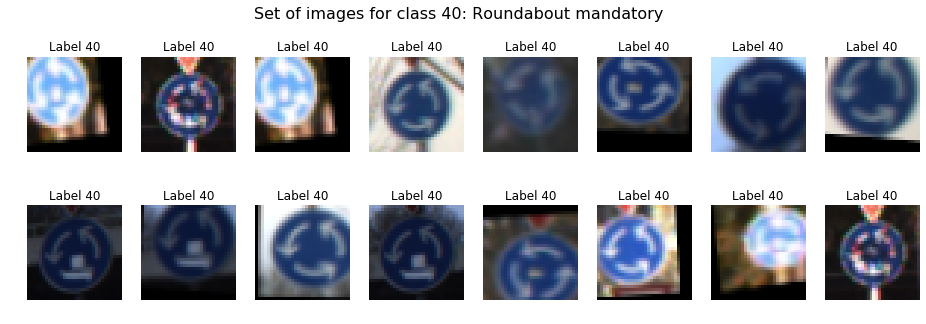

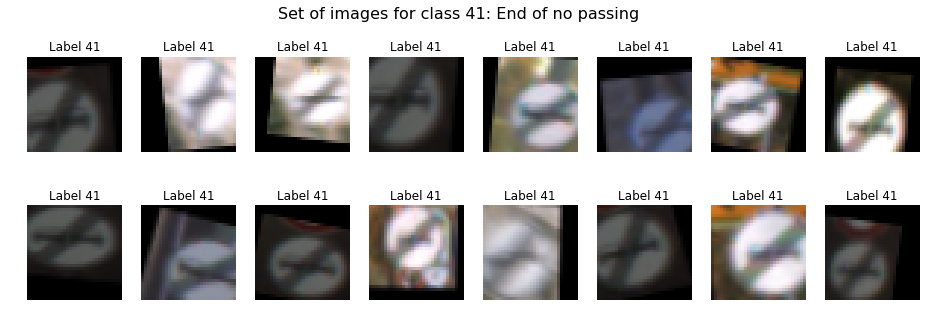

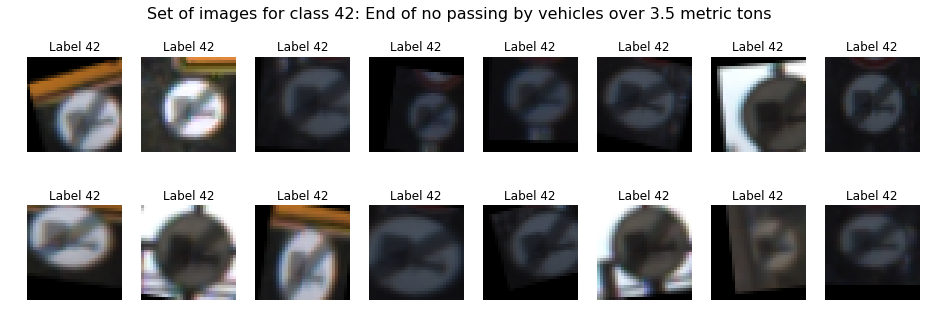

In [10]:
rows = 2
cols = 8

for c in range(len(classes_indexes)):
    fig, ax = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(16,5))
    for i in range(rows):
        for j in range(cols):
            rand_indx = np.random.randint(0, len(classes_indexes[c])-1)
            ax[i,j].imshow(X_train[classes_indexes[c][rand_indx]], cmap='gray')
            ax[i,j].set_title('Label {}'.format(y_train[classes_indexes[c][rand_indx]]))
            ax[i,j].axis('off')  # clear x- and y-axes
    fig.suptitle('Set of images for class {}: {}'.format(c, class_labels[c]), fontsize=16)
    plt.show()

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
from sklearn.utils import shuffle

# Suffle input/outputs so the starting point of data structure is random
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

## Preprocessing methods

Two preprocessing methods were used in this project. The following blocks describe and implement each method.

### 1. Grayscale and normalization

In this method we convert the original image to grayscale using the numpy mean method and normalize the values to be between -1 and 1. 

In [12]:
def preprocessing_grayscale(X):
    # Converting RGB images to GRAY scale
    X_gray = X.mean(axis=-1, keepdims=0)
    # Add one dimension to the tensor
    X_gray = X_gray[:,:,:, np.newaxis]
    # Input normalization from values between 0-255 to -1-1
    X_gray = (X_gray-128.0)/128.0
    return X_gray

### 2. Channel Y of YVU color space, with local/global contrast normalization

In [17]:
import numpy
import scipy
import scipy.misc
from PIL import Image
import skimage as sk


def global_contrast_normalization(X, s, lmda, epsilon):

    # replacement for the loop
    X_average = numpy.mean(X)

    X = X - X_average

    # `sum` is here the mean, instead of the sum
    contrast = numpy.sqrt(lmda + numpy.mean(X**2))

    X = s * X / max(contrast, epsilon)

    return X


def preprocessing_channelY(X):
    images =[]
    # convert image to YUV space, only use the Y channel
    #X=0.299*X[:,:,:,0]+0.587*X[:,:,:,1]+0.114*X[:,:,:,2]
    #X=(X/255.0).astype(np.float32)
    
    for i in range(len(X)):
        y = sk.color.rgb2yuv(X[i])[:,:,0]
        if (i%1000==0):
            print('{}th iteration\n'.format(i))
        # Adaptive Equalization
        y = sk.exposure.equalize_adapthist(y, clip_limit=0.03)
        y = global_contrast_normalization(y, 1, 10, 0.000000001)
        images.append(y[:,:,np.newaxis])
    return np.array(images)

The preprocessing available methods are: `grayscale_normalization` and `channelY_normalization`. The one to be used is defined in the `preprocessing_method` flag.

In [18]:
# Dictionary storing both preprocessing functions
preprocessing = {'grayscale_normalization': preprocessing_grayscale ,'channelY_normalization': preprocessing_channelY}

# Choose one between 'grayscale_normalization' and 'channelY_normalization' 
preprocessing_method = 'channelY_normalization'

In [19]:
X_train_pp = preprocessing[preprocessing_method](X_train)
X_valid_pp = preprocessing[preprocessing_method](X_valid)
X_test_pp =  preprocessing[preprocessing_method](X_test)

0th iteration



C:\Users\juand\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


1000th iteration

2000th iteration

3000th iteration

4000th iteration

5000th iteration

6000th iteration

7000th iteration

8000th iteration

9000th iteration

10000th iteration

11000th iteration

12000th iteration

13000th iteration

14000th iteration

15000th iteration

16000th iteration

17000th iteration

18000th iteration

19000th iteration

20000th iteration

21000th iteration

22000th iteration

23000th iteration

24000th iteration

25000th iteration

26000th iteration

27000th iteration

28000th iteration

29000th iteration

30000th iteration

31000th iteration

32000th iteration

33000th iteration

34000th iteration

35000th iteration

36000th iteration

37000th iteration

38000th iteration

39000th iteration

40000th iteration

41000th iteration

42000th iteration

43000th iteration

44000th iteration

45000th iteration

46000th iteration

47000th iteration

48000th iteration

49000th iteration

50000th iteration

51000th iteration

52000th iteration

53000th iteration

54

In [24]:
# Uncomment this block if you also want to preprocess with the other method. Grayscale normalization in this case
'''
X_train_gray = preprocessing['grayscale_normalization'](X_train)
X_valid_gray = preprocessing['grayscale_normalization'](X_valid)
X_test_gray =  preprocessing['grayscale_normalization'](X_test)
'''

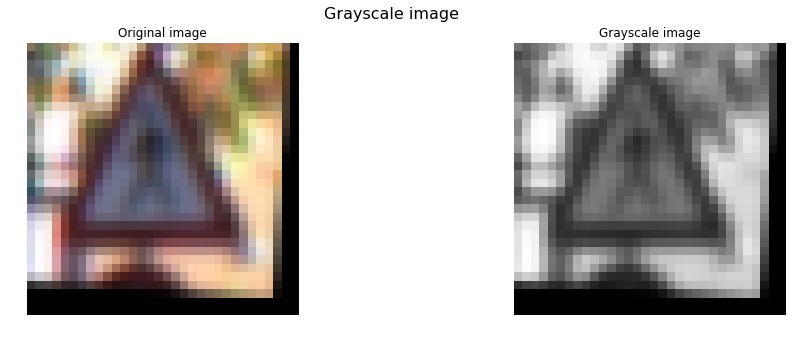

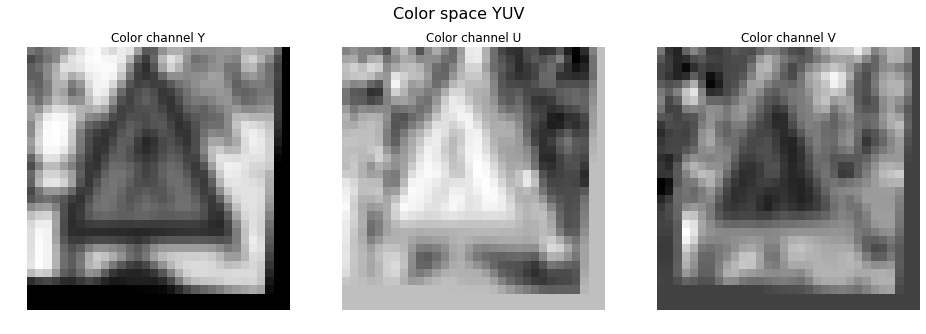

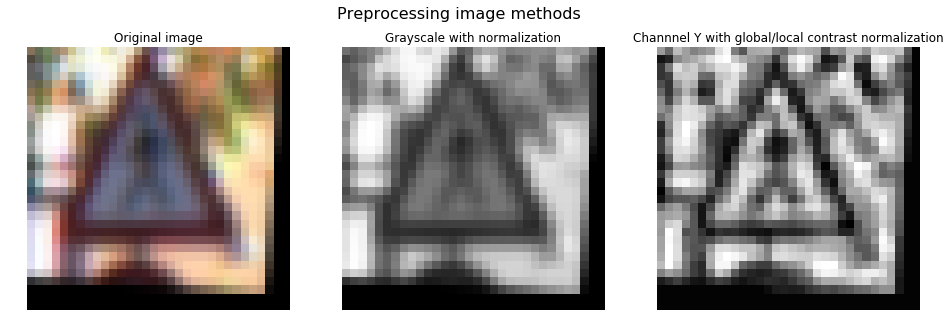

In [20]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

img_index = random_index(X_train.shape[0])
rows = 1
cols = 3

new_image = sk.color.rgb2yuv(X_train[img_index])
color_channel = ['Y', 'U', 'V']

# Image preprocessing of the gray scale version of the image
gray = X_train[img_index].mean(axis=-1,keepdims=0)
gray_n = (gray-128)/128


# Image preprocessing of the y channel version of the image
# Channel y of the image in img_index
y= new_image[:,:,0]
# Local contrast normalization w/ Adaptive Equalization
y = sk.exposure.equalize_adapthist(y, clip_limit=0.03)
# Global contrast normalization
y = global_contrast_normalization(y, 1, 10, 0.000000001)

# Show the different channel of the RGB image in index img_index
fig0, ax0 = plt.subplots(1,2, sharex ='col', sharey='row', figsize=(16,5))
ax0[0].imshow(X_train[img_index])
ax0[0].set_title('Original image')
ax0[0].axis('off')  # clear x- and y-axes

ax0[1].imshow(gray,cmap='gray')
ax0[1].set_title('Grayscale image')
ax0[1].axis('off')  # clear x- and y-axes
fig0.suptitle('Grayscale image', fontsize=16)
plt.show()


# Show the different channel of the RGB image in index img_index
fig, ax = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(16,5))
for i in range(rows):
    for j in range(cols): 
        ax[j].imshow(new_image[:,:,j], cmap='gray')
        ax[j].set_title('Color channel {}'.format(color_channel[j]))
        ax[j].axis('off')  # clear x- and y-axes
fig.suptitle('Color space YUV', fontsize=16)
plt.show()




# Show the original image and its preprocessing after gray scale and y channel conditioning
titles = ['Original image', 'Grayscale with normalization', 'Channnel Y with global/local contrast normalization']
fig1, ax1 = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(16,5))

ax1[0].imshow(X_train[img_index])
ax1[0].set_title('{}'.format(titles[0]))
ax1[0].axis('off')  # clear x- and y-axes

ax1[1].imshow(gray,cmap='gray')
ax1[1].set_title('{}'.format(titles[1]))
ax1[1].axis('off')  # clear x- and y-axes

ax1[2].imshow(y,cmap='gray')
ax1[2].set_title('{}'.format(titles[2]))
ax1[2].axis('off')  # clear x- and y-axes

fig1.suptitle('Preprocessing image methods', fontsize=16)
plt.show()


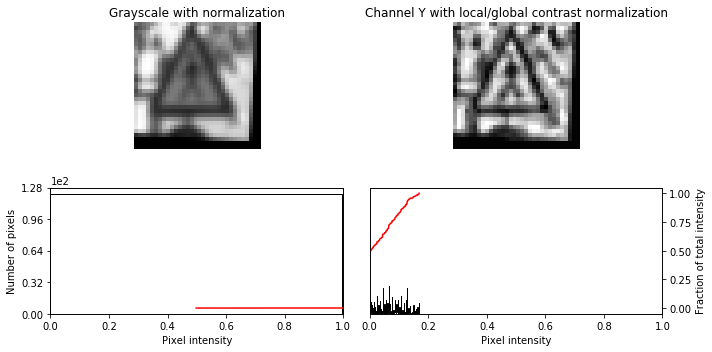

In [21]:
from skimage import data, img_as_float
from skimage import exposure

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf



# Display results
fig = plt.figure(figsize=(10, 5))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 2, 1)
for i in range(1, 2):
    axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 2):
    axes[1, i] = fig.add_subplot(2, 2, 3+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gray, axes[:, 0])
ax_img.set_title('Grayscale with normalization')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(y, axes[:, 1])
ax_img.set_title('Channel Y with local/global contrast normalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

## Plot some of the new images before and after augmentation

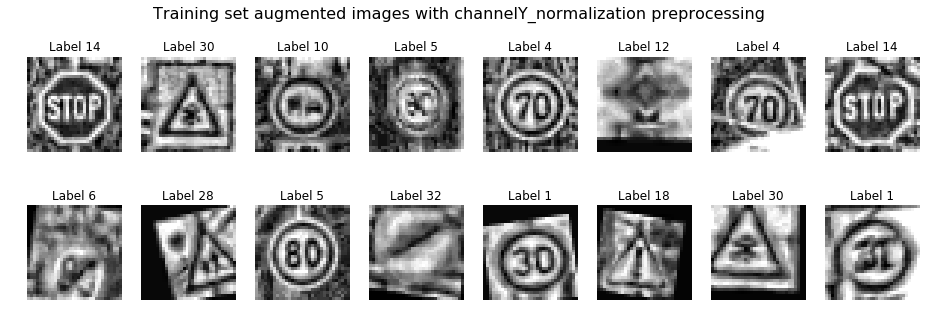

In [22]:
rows = 2
cols = 8

fig, ax = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(16,5))

for i in range(rows):
    for j in range(cols):
        rand_indx = random_index(X_train_pp.shape[0]-1)
        ax[i,j].imshow(X_train_pp[rand_indx][:,:,0], cmap='gray')
        ax[i,j].set_title('Label {}'.format(y_train[rand_indx]))
        ax[i,j].axis('off')  # clear x- and y-axes
fig.suptitle('Training set augmented images with {} preprocessing'.format(preprocessing_method), fontsize=16)
plt.show()


## Save augmented and preprocessed training, validation and testing data

In this block of code we store the augmented and preprocessed training, validation and testing data. Two methods of preprocessing were used in this project: 
* The first one takes a color image, converts it to gray scale taking the mean of its pixel values and then normalizes them to be between -1 and 1. 
* The second method uses local and global contrast normalization over the Y color channel of the YVU color space of the original image.

In [25]:
training_aug_pp = {'features_y': X_train_pp,'features_gray': X_train_gray, 'labels': y_train}
valid_pp = {'features_y': X_valid_pp, 'features_gray': X_valid_gray, 'labels': y_valid}
test_pp = {'features_y': X_test_pp, 'features_gray': X_test_gray, 'labels': y_test}


training_file_aug_pp = "data/train_aug_pp.p"
valid_file_pp = "data/valid_pp.p"
test_file_pp = "data/test_pp.p"


with open(training_file_aug_pp, mode='wb') as f:
    pickle.dump(training_aug_pp, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(valid_file_pp, mode='wb') as f:
    pickle.dump(valid_pp, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(test_file_pp, mode='wb') as f:
    pickle.dump(test_pp, f, protocol=pickle.HIGHEST_PROTOCOL)

## Load preprocessed data

Load data when a preprocessed step has been previously performed. It will load the data in dictionaries with keys: 
* 'features_y': for features preprocessed in the y channel color and local/global contrast normalization
* 'features_gray': for features preprocessed in the grayscale version of the original image and pixel intensity normalization 

In [ ]:
import pickle 
import tensorflow as tf
from sklearn.utils import shuffle

training_file_aug_pp = "data/train_aug_pp.p"
validation_file_pp = "data/valid_pp.p"
testing_file_pp = "data/test_pp.p"

with open(training_file_aug_pp, mode='rb') as f:
    train_pp = pickle.load(f)
with open(validation_file_pp, mode='rb') as f:
    valid_pp = pickle.load(f)
with open(testing_file_pp, mode='rb') as f:
    test_pp = pickle.load(f)

In [ ]:
# Choose between two options: 'features_y' and 'features_gray'
input_method = 'features_y'

X_train_pp, y_train = train_pp[input_method],  train_pp['labels']
X_valid_pp, y_valid = valid_pp[input_method], valid_pp['labels']
X_test_pp, y_test = test_pp[input_method], test_pp['labels']

# How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_test)+list(y_train)+list(y_valid)))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

## Input

This neural network accepts a 32x32x1 image as input, where the final dimension is the number of color channels.
Architecture

## Architecture
Layer 1: Convolutional. The output shape should be 30x30x32.

Activation. Options as activation functions: []

Layer 2: Convolutional. The output shape should be 28x28x64.

Activation. Options as activation functions: []

Pooling. The output shape should be 14x14x64.

Layer 3: Convolutional. The output shape should be 12x12x128.

Activation. Options as activation functions: []

Pooling. The output shape should be 6x6x128.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

Layer 3: Fully Connected. This should have 600 outputs.

Activation. Options as activation functions: []

Layer 4: Fully Connected. This should have 150 outputs.

Activation. Options as activation functions: []

Layer 5: Fully Connected (Logits). This should have 43 outputs.
Output

Return the result of the 2nd fully connected layer.

In [26]:
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()

EPOCHS = 200
BATCH_SIZE = 128
keep_prob1 = 0.7
keep_prob2 = 0.5
input_size = X_train_pp.shape[3]

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1
    
### Define your architecture here.
### Feel free to use as many code cells as needed.
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([3, 3, input_size, 32], mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.random_normal([3, 3, 32, 64], mean = mu, stddev = sigma)),
    'wc3': tf.Variable(tf.random_normal([3, 3, 64, 128], mean = mu, stddev = sigma)),
    'wf1': tf.Variable(tf.random_normal([4608, 600], mean = mu, stddev = sigma)),
    'wf2': tf.Variable(tf.random_normal([600, 150], mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.random_normal([150, n_classes], mean = mu, stddev = sigma))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32], mean = mu, stddev = sigma)),
    'bc2': tf.Variable(tf.random_normal([64], mean = mu, stddev = sigma)),
    'bc3': tf.Variable(tf.random_normal([128], mean = mu, stddev = sigma)),
    'bf1': tf.Variable(tf.random_normal([600], mean = mu, stddev = sigma)),
    'bf2': tf.Variable(tf.random_normal([150], mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.random_normal([n_classes], mean = mu, stddev = sigma))}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')


## Deep neural network funtion for sign classification

In [27]:
def CNet(x):    
    
    # DOne: Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x32.
    # DOne: Activation.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    conv1 = tf.nn.dropout(conv1, keep_prob1)
    
    # DOne: Layer 2: Convolutional. Output = 28x28x64.
    # DOne: Activation.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # DOne: Pooling. Input = 28x28x64. Output = 14x14x64.
    conv2= maxpool2d(conv2)
    
    conv2 = tf.nn.dropout(conv2, keep_prob1)
    
    
    # DOne: Layer 3: Convolutional. Output = 12x12x128.
    # DOne: Activation.
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    
    # DOne: Pooling. Input = 12x12x128. Output = 6x6x128.
    conv3= maxpool2d(conv3)
    
    conv3 = tf.nn.dropout(conv3, keep_prob1)
    
    # DOne: Flatten. Input = 6x6x128. Output = 4608.
    flat1 = flatten(conv3)
    
    # DOne: Layer 3: Fully Connected. Input = 4608. Output = 600.
    fc1 = tf.add(tf.matmul(flat1, weights['wf1']), biases['bf1'])
    # DOne: Activation.
    
    fc1 = tf.nn.relu(fc1)
    #tanh
    fc1 = tf.nn.dropout(fc1, keep_prob2)
    # DOne: Layer 4: Fully Connected. Input = 600. Output = 150.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2'])
    # DOne: Activation.
    fc2 = tf.nn.relu(fc2)
    #tanh
    fc2 = tf.nn.dropout(fc2, keep_prob2)
    # DOne: Layer 5: Fully Connected. Input = 150. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits, conv1, conv2, conv3

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [28]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

x = tf.placeholder(tf.float32, (None, 32, 32, input_size))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, n_classes)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.


In [29]:
rate = 0.001

logits, conv1, conv2, conv3= CNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [30]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

<IPython.core.display.Javascript object>


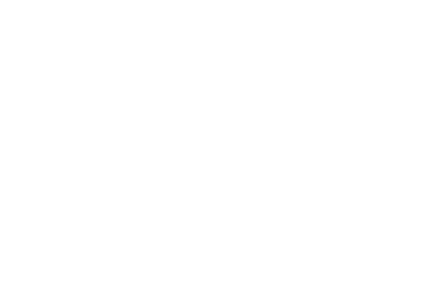

Training...

EPOCH 1 ...
Training Accuracy = 0.028
Validation Accuracy = 0.048

EPOCH 2 ...
Training Accuracy = 0.029
Validation Accuracy = 0.051

EPOCH 3 ...
Training Accuracy = 0.044
Validation Accuracy = 0.080

EPOCH 4 ...
Training Accuracy = 0.320
Validation Accuracy = 0.480

EPOCH 5 ...
Training Accuracy = 0.540
Validation Accuracy = 0.704

EPOCH 6 ...
Training Accuracy = 0.655
Validation Accuracy = 0.817

EPOCH 7 ...
Training Accuracy = 0.733
Validation Accuracy = 0.858

EPOCH 8 ...
Training Accuracy = 0.781
Validation Accuracy = 0.895

EPOCH 9 ...
Training Accuracy = 0.814
Validation Accuracy = 0.910

EPOCH 10 ...
Training Accuracy = 0.840
Validation Accuracy = 0.923

EPOCH 11 ...
Training Accuracy = 0.859
Validation Accuracy = 0.923

EPOCH 12 ...
Training Accuracy = 0.870
Validation Accuracy = 0.931

EPOCH 13 ...
Training Accuracy = 0.886
Validation Accuracy = 0.934

EPOCH 14 ...
Training Accuracy = 0.896
Validation Accuracy = 0.944

EPOCH 15 ...
Training Accuracy = 0.904
Valid

EPOCH 122 ...
Training Accuracy = 0.979
Validation Accuracy = 0.974

EPOCH 123 ...
Training Accuracy = 0.980
Validation Accuracy = 0.970

EPOCH 124 ...
Training Accuracy = 0.980
Validation Accuracy = 0.971

EPOCH 125 ...
Training Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 126 ...
Training Accuracy = 0.980
Validation Accuracy = 0.970

EPOCH 127 ...
Training Accuracy = 0.980
Validation Accuracy = 0.968

EPOCH 128 ...
Training Accuracy = 0.981
Validation Accuracy = 0.968

EPOCH 129 ...
Training Accuracy = 0.981
Validation Accuracy = 0.973

EPOCH 130 ...
Training Accuracy = 0.981
Validation Accuracy = 0.971

EPOCH 131 ...
Training Accuracy = 0.981
Validation Accuracy = 0.973

EPOCH 132 ...
Training Accuracy = 0.980
Validation Accuracy = 0.969

EPOCH 133 ...
Training Accuracy = 0.981
Validation Accuracy = 0.972

EPOCH 134 ...
Training Accuracy = 0.982
Validation Accuracy = 0.971

EPOCH 135 ...
Training Accuracy = 0.980
Validation Accuracy = 0.970

EPOCH 136 ...
Training Accuracy = 

<IPython.core.display.Javascript object>


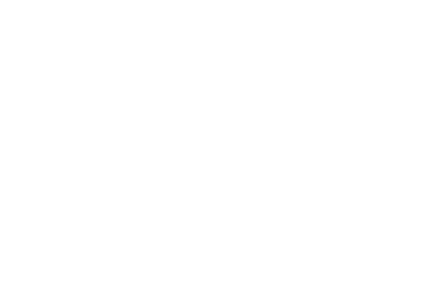

In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
#import numpy as np
#import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

training = []
validation = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_pp)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_pp, y_train = shuffle(X_train_pp, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_pp[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        training_accuracy = evaluate(X_train_pp, y_train)
        validation_accuracy = evaluate(X_valid_pp, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        training.append(training_accuracy)
        validation.append(validation_accuracy)
        x_vals = np.linspace(1, len(training), len(training))
        ax.clear()
        ax.plot(x_vals, training,'b-', x_vals, validation, 'g-', linewidth=2)

        ax.legend(('Training accuracy', 'Validation accuracy'),
                   loc='upper right')
        
        ax.set(xlabel='Epochs', ylabel='Accuracy',
        title='Model training and validation')
        
        ax.set_ylim(0,1.2)
        ax.set_yticks(np.arange(0,1.1, step=0.1))
        
        step_sample = len(training)//20 + 1 
        ax.set_xticks(np.arange(1, len(training)+1, step=step_sample))
        
        ax.grid(b=True, axis ='y')

        fig.canvas.draw()
        
    saver.save(sess, './Cnet_3conv_y_0001')
    print("Model saved")
    #sess.close()

<IPython.core.display.Javascript object>


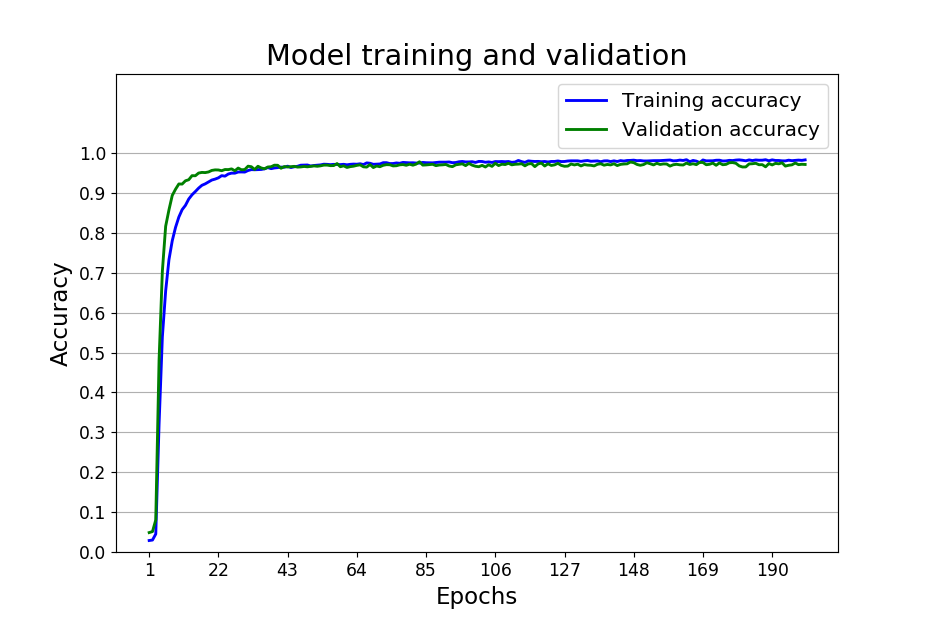

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

x_vals = np.linspace(1, len(training), len(training))

ax1.plot(x_vals, training,'b-', x_vals, validation, 'g-', linewidth=2)

ax1.legend(('Training accuracy', 'Validation accuracy'),
           loc='upper right', fontsize=14)

ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_title('Model training and validation', fontsize=20)


ax1.set_ylim(0,1.2)
ax1.set_yticks(np.arange(0,1.1, step=0.1))
step_sample = len(training)//10 + 1 
ax1.set_xticks(np.arange(1, len(training)+1, step=step_sample))
ax1.tick_params(labelsize=12)
ax1.grid(b=True, axis ='y')

fig1.show()

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [37]:
keep_prob1 = 1
keep_prob2 = 1

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_pp, y_test)
    print("Test Accuracy = {:.3f}%".format(test_accuracy*100))
    sess.close()

INFO:tensorflow:Restoring parameters from .\Cnet_3conv_y_0001
Test Accuracy = 94.893%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [38]:
import cv2

IMAGE_SIZE = 32

def resize_images(X_img_file_paths):
    X_data = []
        
    # Each image is resized individually as different image may be of different size.
    for index, file_path in enumerate(X_img_file_paths):
        img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
        resized_img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
        X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

0th iteration



C:\Users\juand\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


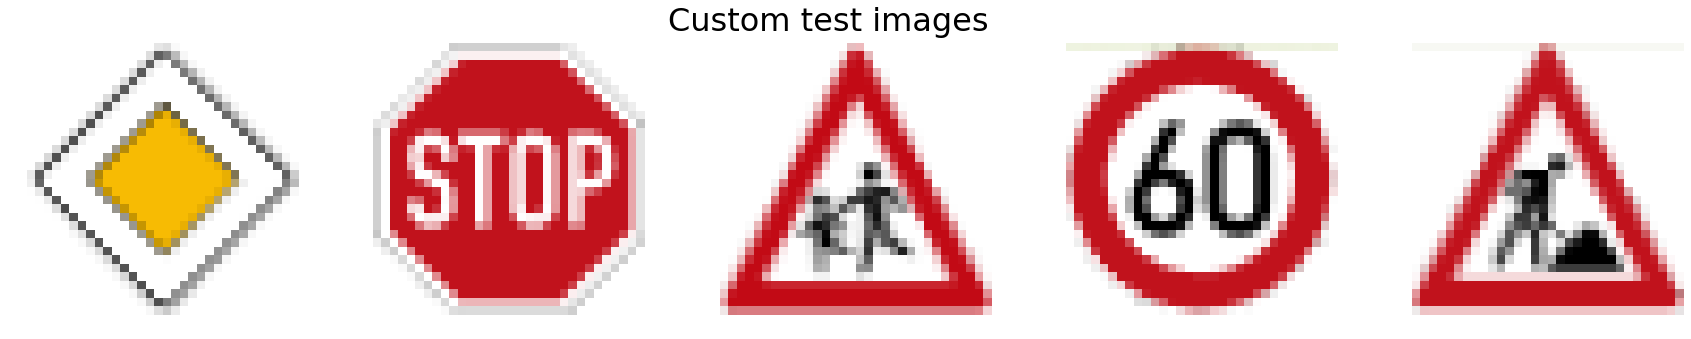

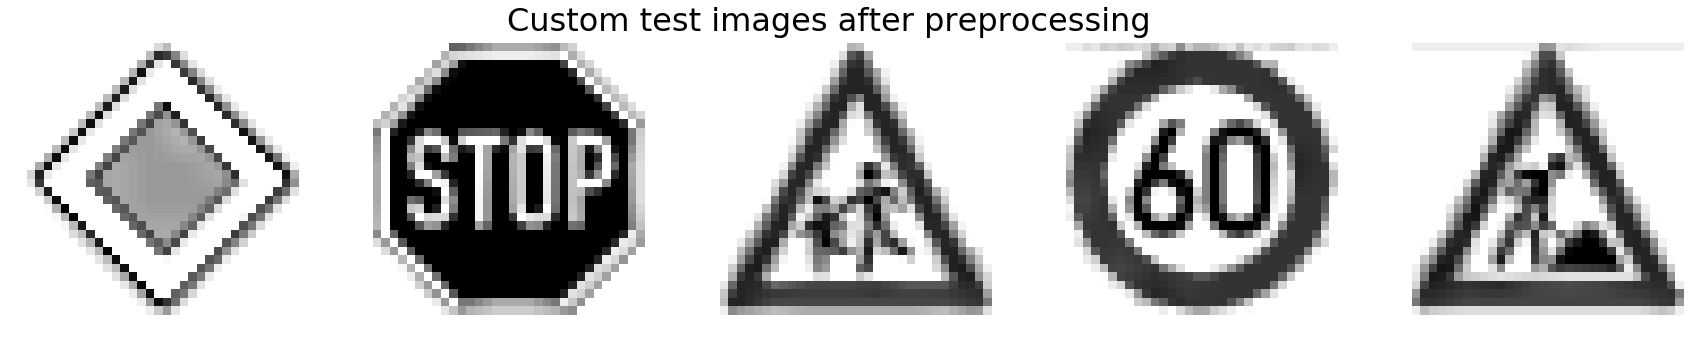

In [40]:
import matplotlib.image as mpimg
import glob
import numpy as np
from skimage import color
from skimage import exposure
import skimage as sk

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline



### Load the images and plot them here.
### Feel free to use as many code cells as needed.
images = sorted(glob.glob('test_images/0*.png'))
im_array =resize_images(images)

im_array_pp = preprocessing[preprocessing_method](im_array)

rows = 1
cols = 5

fig1, ax1 = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(30,5))
for i in range(rows):
    for j in range(cols):
        # Converting RGB images to GRAY scale
        #img = img.mean(axis=-1,keepdims=0)
        #img = (img - 128)/128.0
       
        ax1[j].imshow(im_array[j])
        ax1[j].axis('off')  # clear x- and y-axes
        
        #img = img[:,:,np.newaxis] 
        #ext_test.append(img)
fig1.suptitle('Custom test images', fontsize=32)
plt.show()


fig, ax = plt.subplots(rows,cols, sharex ='col', sharey='row', figsize=(30,5))


ext_test = []
for i in range(rows):
    for j in range(cols):
        # Converting RGB images to GRAY scale
        #img = img.mean(axis=-1,keepdims=0)
        #img = (img - 128)/128.0
       
        ax[j].imshow(im_array_pp[j][:,:,0], cmap='gray')
        ax[j].axis('off')  # clear x- and y-axes
        
        #img = img[:,:,np.newaxis] 
        #ext_test.append(img)
fig.suptitle('Custom test images after preprocessing', fontsize=32)
plt.show()

### Predict the Sign Type for Each Image

In [41]:
prediction = tf.argmax(logits, 1) 

def predict(X_data, Y_data):
    sess = tf.get_default_session()
    pred = sess.run(prediction, feed_dict={x: X_data, y: Y_data})
    return pred

In [42]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
y_images = np.array([12,14,28,3,25])

keep_prob1 = 1
keep_prob2 = 1

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = predict(im_array_pp, y_images)
    print("Preditions= {}".format(list(predictions)))
    sess.close()

    

INFO:tensorflow:Restoring parameters from .\Cnet_3conv_y_0001
Preditions= [12, 14, 28, 3, 25]


### Analyze Performance

In [43]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
results = np.equal(y_images, np.array(predictions))
accuracy = np.mean(results)
print('Performance of the model: {:.2f}%'.format(accuracy*100))

Performance of the model: 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.


In [44]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def softmax(X_data):
    sess = tf.get_default_session()
    softmax_values = tf.nn.softmax(logits)
    top_5 = sess.run(tf.nn.top_k(softmax_values, k = 5), feed_dict={x: X_data})
    return top_5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    values = softmax(im_array_pp)
    print("Top 5 values per image= {}".format(values))
    sess.close()


INFO:tensorflow:Restoring parameters from .\Cnet_3conv_y_0001
Top 5 values per image= TopKV2(values=array([[1.0000000e+00, 3.4355370e-29, 2.4644261e-29, 1.7998635e-31,
        1.0450323e-31],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [1.0000000e+00, 1.1726553e-16, 2.5713342e-20, 8.6555071e-22,
        1.0257972e-24],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [1.0000000e+00, 3.0420428e-31, 9.3102734e-35, 8.0122104e-38,
        5.2348492e-38]], dtype=float32), indices=array([[12, 25, 29,  3, 40],
       [14,  0,  1,  2,  3],
       [28, 29,  3,  1, 22],
       [ 3,  0,  1,  2,  4],
       [25, 22, 23, 20, 28]]))


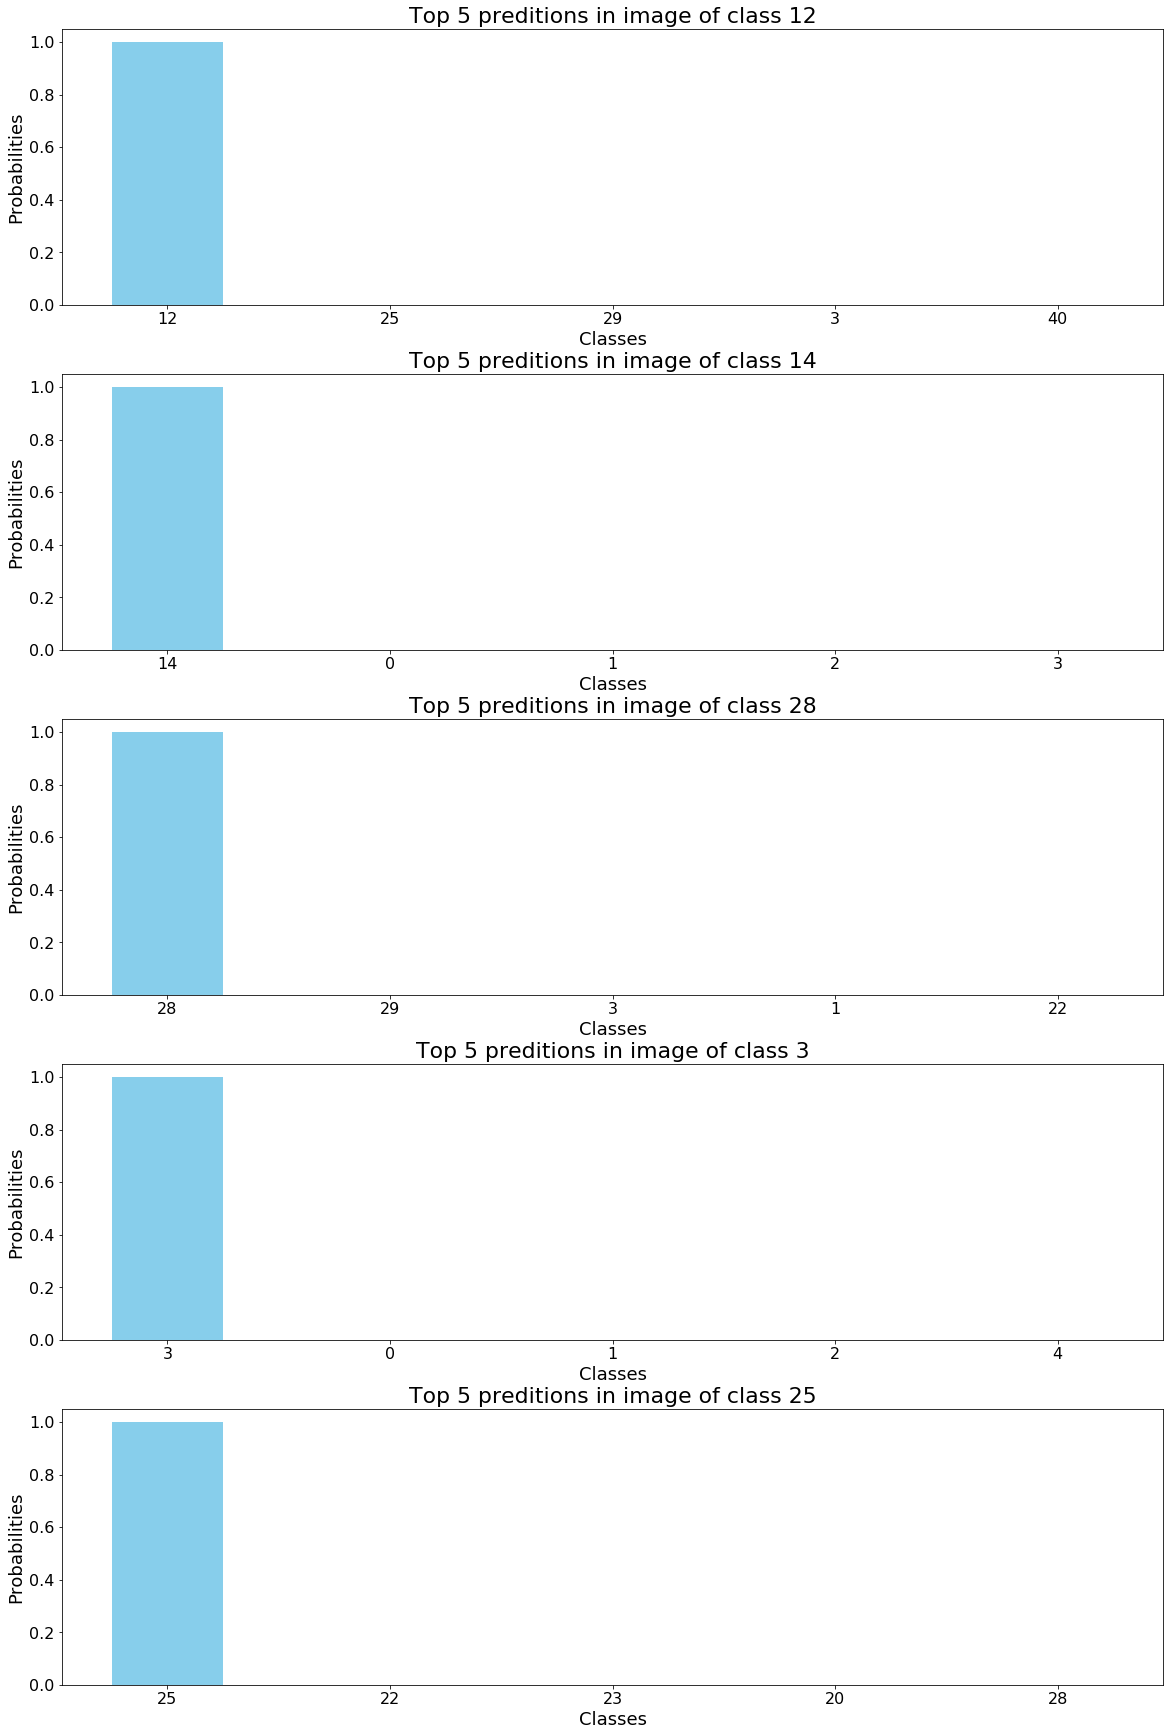

In [45]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.5  # the width of the bars

fig, ax = plt.subplots(5,1, sharey='row', figsize=(18,25))

for j in range(5):
    ind = np.arange(len(values.values[j]))  # the x locations for the groups
    ax[j].bar(ind, values.values[j], width,
                    color='SkyBlue')
    #rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
    #                color='IndianRed', label='Women')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[j].set_ylabel('Probabilities', fontsize=18)
    ax[j].set_xlabel('Classes', fontsize=18)
    ax[j].set_xticks(ind)
    ax[j].set_xticklabels((str(values.indices[j][0]), str(values.indices[j][1]), str(values.indices[j][2]), str(values.indices[j][3]), str(values.indices[j][4])))
    ax[j].set_title('Top 5 preditions in image of class {}'.format(y_images[j]), fontsize=22)
    ax[j].tick_params(labelsize=16)
    
plt.subplots_adjust(top=0.92, bottom=0.0, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


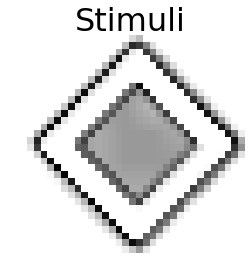

In [46]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    sess = tf.get_default_session()
    activation = sess.run(tf_activation,feed_dict={x:image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
# Stimuli
stimuli = im_array_pp[0]

fig, ax = plt.subplots()

ax.imshow(stimuli[:,:,0], cmap='gray')
ax.axis('off')  # clear x- and y-axes
fig.suptitle('Stimuli', fontsize=32)

plt.show()

INFO:tensorflow:Restoring parameters from .\Cnet_3conv_y_0001


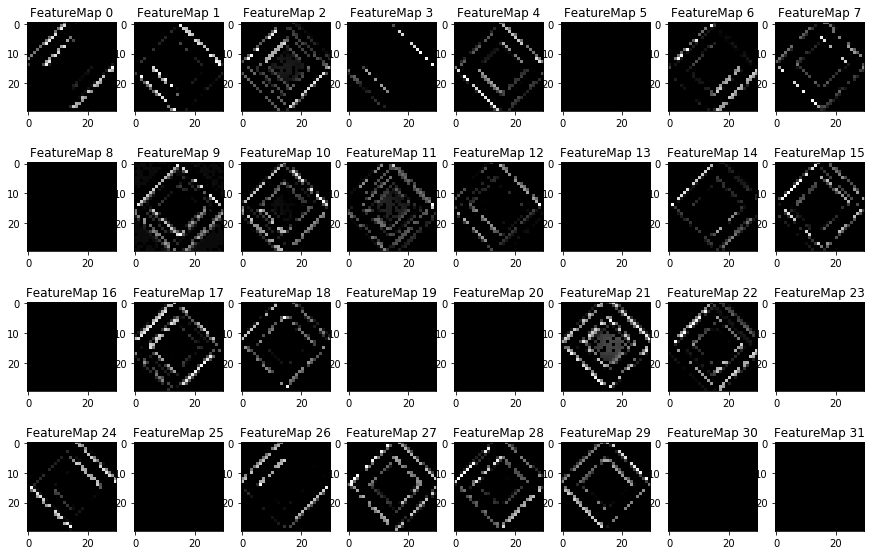

In [47]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sample_input = im_array_pp[0][np.newaxis,:,:,:]
    outputFeatureMap(sample_input, conv1)
    sess.close()